# Import modules and init in gee


In [ ]:
# %matplotlib widget

In [1]:
import copy
import pickle
from datetime import datetime, timedelta
import itertools
import os
# import matplotlib
import joblib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, mean_absolute_percentage_error, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectFromModel
from sklearn import tree

from scipy.stats.mstats import theilslopes
from scipy.optimize import curve_fit
from hampel import hampel


plt.rcParams['axes.edgecolor'] = 'blue'
plt.rcParams['figure.figsize'] = [14, 7]

In [2]:
import ee
import geemap.core as geemap

In [3]:
ee.Authenticate()

True

In [4]:
ee.Initialize(project='ee-airgit1')

In [5]:
def convert_degreendmin_to_degree(_data_frame: pd.DataFrame, name_of_col: str):
    """Convert degree with minutes to degree

    Returns:
        pd.DataFrame: DataFrame where column "name_of_col" is swaped
    """
    data_frame = copy.deepcopy(_data_frame)
    data_list = data_frame[name_of_col].tolist()
    for i, item in enumerate(data_list):
        integer, frac = item.split(' ')
        data_list[i] = integer + str(float(frac) / 60)[1:]
    data_frame[name_of_col] = data_list
    return data_frame


def convert_datetime_irkutsk(_data_frame: pd.DataFrame):
    """Convert columns "DATE", "TIME" to type "datetime" in gee (UTC-0)

    Returns:
        pd.DataFrame: DataFrame where columns "DATE", "TIME" are merged
    """
    data_frame = copy.deepcopy(_data_frame)
    converted_list = data_frame["DATE"].tolist()
    for i in range(converted_list.__len__()):
        tmp = converted_list[i].split('/')
        date = [tmp[-1], tmp[0], tmp[1]]
        converted_list[i] = '-'.join(date) + \
            ' ' + data_frame["TIME"][i] + ":00"
        dt_datetime = datetime.strptime(converted_list[i], '%Y-%m-%d %H:%M:%S')
        dt_datetime -= timedelta(hours=8)
        converted_list[i] = dt_datetime.strftime('%Y-%m-%dT%H:%M:%S')

    data_frame["datetime"] = converted_list
    data_frame = data_frame.drop(columns=['DATE', 'TIME'])
    return data_frame

In [6]:
_df_irk = pd.read_csv("data_chl/irk_all.csv")
_df_sev = pd.read_csv('data_chl/sevastopol.csv', index_col=0)

for k in _df_sev.datetime.index:
    dt_datetime = datetime.strptime(_df_sev.loc[k, 'datetime'], '%Y-%m-%d %H:%M:%S')
    _df_sev.loc[k, 'datetime'] = dt_datetime.strftime('%Y-%m-%dT%H:%M:%S')
_df_sev.rename(columns={'Latitude': 'LATITUDE', 'Longitude': 'LONGITUDE'}, inplace=True)

wind_values = np.array(_df_irk['Wind'].tolist())
wind_values = np.strings.replace(wind_values, ',', '.')
for i, ai in enumerate(wind_values):
    if '(' in ai:
        wind_values[i] = ai[ai.find('(') + 1 : ai.find(')')]
    elif '-' in ai:
        wind_values[i] = np.nan
    elif 'штиль' in ai:
        wind_values[i] = 0.3
wind_values = np.array(wind_values, dtype='float')

_df_irk["Wind"] = wind_values
_df_irk = convert_datetime_irkutsk(_df_irk)  

# df_all = _df_irk.merge(_df_sev, how='outer')

In [7]:
pd.concat([_df_irk, _df_sev]).to_csv("chl_data.csv")

In [ ]:
df_all = copy.deepcopy(_df_sev)

In [38]:
_df_all = pd.concat([_df_irk, _df_sev])
THRESHOLD = _df_all['CHL'].quantile(0.95)
df_all = _df_all[_df_all['CHL'] <= THRESHOLD]

In [ ]:
# df_all = copy.deepcopy(_df_all)

# Implementation


## Function definition

### scale and mask

In [8]:
def scale_msi(image):
    opticalBands = image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A']).multiply(0.0001)
    return image.addBands(opticalBands, None, True)


def mask_S2_clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    opticalBands = image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A'])
    
    mask_gt = opticalBands.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A']) \
        .reduce(ee.Reducer.min()).gt(0)
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
        .And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask.And(mask_gt))

### preproc images

In [9]:
def preproc(ic: ee.ImageCollection, df: pd.DataFrame) -> list:
    """Mapping of id (datetime) to Image

    Args:
        ic (ee.ImageCollection): initial dataset
        df (pd.DataFrame): .csv
    
    Returns:
        dictionary of [ee.Image, dict of bands reduceRegion]
    """
    
    dict_stats = {key: value for key, value in zip(df.index.to_list(), df['datetime'].to_list())}
    for i in dict_stats:
        date_of_observation = ee.Date(df['datetime'][i])
        start_date = date_of_observation.advance(-1, 'day')
        end_date = date_of_observation.advance(1, 'day')
        
        img = ic.filterDate(start_date, end_date) \
            .filterBounds(ee.Geometry.Point(float(df['LONGITUDE'][i]), float(df['LATITUDE'][i]))) \
                .map(scale_msi).map(mask_S2_clouds)
        found_stats = [None, None]
        if img.size().getInfo():
            img = img.toList(img.size())
            for j in range(img.length().getInfo()):
                v_mean = ee.Image(img.get(j)).reduceRegion(
                            reducer=ee.Reducer.median(),
                            geometry=ee.Geometry.Point(float(df['LONGITUDE'][i]), float(df['LATITUDE'][i])),
                            scale=20
                        ).getInfo()
                if v_mean['B3'] is not None:
                    found_stats[0] = ee.Image(img.get(j))
                    found_stats[1] = v_mean
                    break
        dict_stats[i] = found_stats
        
    for k, v in list(dict_stats.items()):
        if v[1] is None:
            del dict_stats[k]
    # for k, v in dict_stats.items():
    #     display(v[0], df.iloc[k])
    return dict_stats

### caclulation statistics

In [10]:
def mae_log(in_situ, pred):
    res = 0
    y_pred_pos = np.maximum(np.array(pred), 0.01)
    for i, ai in enumerate(in_situ):
        res += abs(np.log10(y_pred_pos[i]) - np.log10(ai))
    res /= len(in_situ)
    return 10 ** res


def bias_log(in_situ, pred):
    res = 0
    y_pred_pos = np.maximum(np.array(pred), 0.01)
    for i, ai in enumerate(in_situ):
        res += np.log10(y_pred_pos[i]) - np.log10(ai)
    res /= len(in_situ)
    return 10 ** res


def r2_cov(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    y_bar = y.mean()
    y_pred_bar = y_pred.mean()
    return np.pow(np.sum((y - y_bar) * (y_pred - y_pred_bar)) /
                  np.sqrt(np.sum(np.pow(y - y_bar, 2)) * np.sum(np.pow(y_pred - y_pred_bar, 2))), 2)
    
    
def bias(in_situ, pred):
    res = 0
    for i, ai in enumerate(in_situ):
        res += (pred[i] - ai)
    return res / len(in_situ)


def sen_slope(list_in_situ, list_calc):
    return theilslopes(list_in_situ, list_calc).slope


def std(in_situ, pred):
    return np.std(np.array(pred) - np.array(in_situ))


def calculate_statistics(list_in_situ, list_calc):
    arr = [r2_cov(list_in_situ, list_calc), bias_log(list_in_situ, list_calc),
            bias(list_in_situ, list_calc), mae_log(list_in_situ, list_calc), mean_absolute_error(list_in_situ, list_calc),
            np.sqrt(mean_squared_error(list_in_situ, list_calc)), std(list_in_situ, list_calc),
            sen_slope(list_calc, list_in_situ), mean_absolute_percentage_error(list_in_situ, list_calc) * 100]
    return list(map(lambda x: round(x, 3), arr))

### draw and estimated chl

In [11]:
def draw_graphic(list1: list, list2: list, name_algo: str, save_folder: str = None):
    x = np.array(copy.deepcopy(list1)).reshape((-1, 1))
    y1 = np.array(copy.deepcopy(list2))
    model = LinearRegression().fit(x, y1)
    x_dots = np.linspace(x.min(), x.max(), 100).reshape((-1, 1))
    y_pred = model.predict(x_dots)
    
    plt.figure()
    plt.scatter(x, y1, c=[(0.7, 0.2, 0.9)], s=150,
                edgecolor='black',      # Черная обводка
                linewidth=1.5,         # Толщина обводки
                alpha=0.9,             # Легкая прозрачность
                marker='o',            # Форма маркера
                zorder=3)
    plt.plot(x_dots, y_pred, 'b', label='linear regression')
    plt.plot(x_dots, (st := theilslopes(list2, list1)).slope * x_dots + st.intercept, color='green', label='Theil–Sen estimator')
    plt.plot(x_dots, x_dots, '--', color='black', label='1:1 line')
    plt.xlabel(f"in_situ, Ug/L\nN = {len(list1) if 1 else 0}, Sen\'s slope = {st.slope:.3f}", fontsize=16, labelpad=10)
    plt.ylabel(f"{name_algo}, Ug/L", fontsize=16, labelpad=10)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    if save_folder:
        os.makedirs(f"graphics/{save_folder}", exist_ok=True)
        filename = f"{name_algo}.png"
        save_path = os.path.join(f"graphics/{save_folder}", filename)
        
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()  # Закрыть фигуру после сохранения
    else:
        plt.show()   # Показать график, если сохранение не требуется
        
    return round(std(list1, list2), 3)
    
    
def calculate_statistics_and_draw_graphic(df_in_situ: pd.DataFrame, **kwargs):
    dict_in_situ = {key: value for key, value in zip(df_in_situ.index.to_list(), df_in_situ['CHL'].to_list())}
    statistics = dict()
    for algo_name, algo_dict in kwargs.items():
        tmp_copy_calc = copy.deepcopy(algo_dict)
        for k, v in tmp_copy_calc.items():
            if v is None or v <= 0 or np.isnan(v) or abs(dict_in_situ[k] - tmp_copy_calc[k]) > 100:
                # print(f"\tOutlier algorithm \"{algo_name}\": calculated_chl = {tmp_copy_calc[k]} (ID = {k})\n")
                del algo_dict[k]
            # elif :
            #     print(f"\tOutlier {algo_name}: calculated_chl = {tmp_copy_calc[k]} (ID = {k})\n")
            #     del algo_dict[k]
        tmp_copy_in_situ = copy.deepcopy(dict_in_situ)
        for k in list(tmp_copy_in_situ.keys()):
            if k not in algo_dict:
                del tmp_copy_in_situ[k]
        
        # for k, v in algo_dict.items():
        #     print(f"ID: {k}, in situ: {dict_in_situ[k]}, chl: {v}, dif: {abs(dict_in_situ[k] - v)}")
                
        in_situ_values = list(tmp_copy_in_situ.values())
        calc_chl = list(algo_dict.values())
        # print(in_situ_values)
        # print(calc_chl)
        if len(calc_chl) > 3:
            statistics[algo_name] = [*(_tmp := calculate_statistics(in_situ_values, calc_chl)), len(calc_chl), tmp_copy_in_situ, algo_dict]
            slope = draw_graphic(in_situ_values, calc_chl, algo_name, save_folder="regional")
            # statistics[algo_name].insert(6, slope)
        else:
            display(f"Incorrect estimated values (count = {len(calc_chl)}): {algo_name}")
        
    return statistics

### formulae in articles

#### Beck

In [12]:
def beck(values: dict):
    ndci = (values['B5'] - values['B4']) / (values['B5'] + values['B4']) 
    flh_violet = values['B3'] - (values['B4'] + ((665 - 560.5) / (665 - 490.5) * (values['B2'] - values['B4'])))
    _2bda = values['B5'] / values['B4']
    _3bda = ((1 / values['B4']) - (1 / values['B5'])) * values['B8A']
    
    ndci_chl = None if (_ndci := 0.388 * ndci - 18.844) < 0 else _ndci
    flh_violet_chl = None if (_flh_violet_chl := -0.033 * flh_violet + 53.064) < 0 else _flh_violet_chl
    _2bda_chl = None if (__2bda_chl := _2bda * 86.148 - 51.94) < 0 else __2bda_chl
    _3bda_chl = None if (__3bda_chl := 156.286 * _3bda + 35.982) < 0 else __3bda_chl
    return ndci_chl, flh_violet_chl, _2bda_chl, _3bda_chl

#### Molkov

In [13]:
def molkov_linear(x, a, b):
    a = np.array(a)
    b = np.array(b)
    return None if x is None or (_ := a * x + b) < 0 else _
    
    
def molkov_poly(x, a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return None if x is None or (_ := a * np.pow(x, 2) + b * x + c) < 0 else _ 


def molkov_exp(x, a, b):
    a = np.array(a)
    b = np.array(b)
    return None if x is None else a * np.exp(b * x)
    
    
def molkov_power1(x, a, b):
    a = np.array(a)
    b = np.array(b)
    return None if x is None else a * np.pow(x, b)
    

def molkov_power2(x, a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    return None if (x is None) or np.any(a * x + b < 0) else np.pow((a * x + b), c)
        

def molkov(values: dict) -> tuple:
    """For each values of bands calculate indecies, which looks like lists [lin, poly, exp, p1, p2]

    Returns:
        tuple of lists: dim = 8: ndci_list, _2bda_list, _3bda_list, ph_list, \n
        _2b_linear_result, _2b_poly_result, ndci_linear_result, ndci_poly_result
    """
    
    ndci = (values['B5'] - values['B4']) / (values['B5'] + values['B4'])
    _2bda = values['B5'] / values['B4']
    _3bda = ((1 / values['B4']) - (1 / values['B5'])) * values['B6']
    ph = values['B5'] - (values['B6'] + values['B4']) / 2
    
    # fit_keys = ["linear", "poly" ,"exp", "power #1", "power #2"] 
    ndci_list, _2bda_list, _3bda_list, ph_list = np.zeros(5, dtype=np.float64), np.zeros(5, dtype=np.float64), \
        np.zeros(5, dtype=np.float64), np.zeros(5, dtype=np.float64)
    
    ndci_list[0], _2bda_list[0], _3bda_list[0], ph_list[0] = molkov_linear(ndci, 90.101, 13.75), \
        molkov_linear(_2bda, 24.463, -8.356), molkov_linear(_3bda, 35.812, 19.24), molkov_linear(ph, 2340.123, 9.185)
    
    ndci_list[1], _2bda_list[1], _3bda_list[1], ph_list[1] = molkov_poly(ndci, 88.757, 52.715, 15.06), \
        molkov_poly(_2bda, -2.155, 33.034, -15.59), molkov_poly(_3bda, -10.227, 52.867, 16.91), molkov_poly(ph, -17567.0, 2814.313, 7.11)
    
    ndci_list[2], _2bda_list[2], _3bda_list[2], ph_list[2] = molkov_exp(ndci, 16.365, 2.754), \
        molkov_exp(_2bda, 12.546, 0.526), molkov_exp(_3bda, 25.114, 0.554), molkov_exp(ph, 17.808, 52.313)
    
    ndci_list[3], _2bda_list[3], _3bda_list[3], ph_list[3] = None, molkov_power1(_2bda, 17.346, 1.198), \
        None, molkov_power1(ph, 890.568, 0.708)
    
    ndci_list[4], _2bda_list[4], _3bda_list[4], ph_list[4] = molkov_power2(ndci, 6.251, 3.359, 2.217), \
        molkov_power2(_2bda, 96.806, -61.71, 0.764), molkov_power2(_3bda, 4373.068, 296.6, 0.479), molkov_power2(ph, 7834.173, 8.051, 0.789)
    
    _2b_linear_result = molkov_linear(_2bda, 64.536, -57.8)
    _2b_poly_result = molkov_poly(_2bda, -73.669, 252.808, -176.68)
    ndci_linear_result = molkov_linear(ndci, 167.293, 4.756)
    ndci_poly_result = molkov_poly(ndci, -300.26, 235.556, 1.586)
    return ndci_list, _2bda_list, _3bda_list, ph_list, \
        _2b_linear_result, _2b_poly_result, ndci_linear_result, ndci_poly_result


def convert_molkov_dict(index_dict: dict) -> tuple:
    """For each pair flatten lists to dict: id: [0, 1, 2, ...] -> dict(id: 0), dict(id: 1), ...

    Returns:
        tuple of dicts
    """
    _0, _1, _2, _3, _4 = dict(), dict(), dict(), dict(), dict()
    for k, v in index_dict.items():
        _0[k] = v[0]
        _1[k] = v[1]
        _2[k] = v[2]
        _3[k] = v[3]
        _4[k] = v[4]
    return _0, _1, _2, _3, _4

#### Li

In [14]:
def li_candidate13(x, a0, a1, a2, a3, a4):
    """
    Args:
        x: np.log10(values['B2'] / values['B3'])
    """
    return np.pow(10, a0 + a1 * x + a2 * np.pow(x, 2) + a3 * np.pow(x, 3) + a4 * np.pow(x, 4))


def li_candidate(values: dict):
    """
    ndci = None if values['B5'] < values['B4'] else (values['B5'] - values['B4']) / (values['B5'] + values['B4']) 
    _2bda1 = values['B6'] / values['B5']
    _2bda2 = values['B5'] / values['B4']
    _3bda = None if values['B5'] < values['B4'] else ((1 / values['B4']) - (1 / values['B5'])) * values['B6']
    """
    
    chl11 = None if (__chl11 := 136.3 * (values['B6'] / values['B4']) - 16.2) < 0 else __chl11
    
    chl12 = None if (__chl12 := 25.28 * (_chl12 := values['B5'] / values['B4'])**2 + 14.85 * _chl12 - 15.18) < 0 else __chl12
    
    chl13 = np.pow(10, 0.2389 - 1.9369 * (_chl13 := np.log10(values['B2'] / values['B3'])) +
                   1.7627 * _chl13**2 - 3.0777 * _chl13**3 - 0.1054 * _chl13**4)
    
    
    chl211 = None if \
        (__chl211 := 117.42 * ((1 / values['B4']) - (1 / values['B5'])) * values['B6'] + 23.09) < 0 else __chl211
        
    chl212 = None if \
        (__chl212 := 232.329 * ((1 / values['B4']) - (1 / values['B5'])) * values['B6'] + 23.174) < 0 else __chl212
        
    chl213 = None if \
        (__chl213 := 315.50 * (_chl213 := ((1 / values['B4'] - 1 / values['B5']) * values['B6']))**2 +
                      215.95 * _chl213 + 25.66) < 0 else __chl213
        
    chl22 = None if values['B6'] == values['B5'] or (__chl22 := \
        161.24 * (((1 / values['B4']) - (1 / values['B5'])) / ((1 / values['B6']) - (1 / values['B5']))) + 28.04) < 0 else __chl22
    return chl11, chl12, chl13, chl211, chl212, chl213, chl22

#### Makwinja

In [15]:
def makwinja(values: dict):  # > 2.5 min in lake Malombe/
    ndci = (values['B5'] - values['B4']) / (values['B5'] + values['B4'])
    return None if (_ndci := 431.98 * ndci**2 + 104 * ndci + 9.547) < 0 else _ndci

#### Boldanova

In [16]:
def boldanova(values: dict):
    # _1 = None if \
    #     (__1 := -6.16 * (values['B2'] - values['B4']) / values['B3'] + 5.44) <0 else __1
    # _2 = None if (__2 := 102.14 * values['B3'] - 194.55 * values['B4'] + 253. * values['B5'] - 38.13 * values['B6'] - 0.89) < 0 \
    #     else __2
    # _3 = None if (__3 := -0.02 * (1 / values['B4']) + 1.25 * (values['B6'] / values['B5']) + 3.010) < 0 \
    #     else __3
    # _4 = None if values['B7'] == values['B6'] or \
    #     (__4 := 1.49 * ((1 / values['B4']) - (1 / values['B5'])) / ((1 / values['B7']) - (1 / values['B6']) + 3.54)) < 0 else __4 
    # _5 = None if ( __5 := 4.45 * values['B5'] / values['B4'] - 0.75) < 0 else __5
    # _6 = None if (__6 := 1.36 * (values['B6'] * ((1 / values['B4']) - (1 / values['B5']))) + 3.52) < 0 else __6
    boldanova_b3 = None if (_boldanova_b3 := 3635.4 * (values['B3'])**2 - 185.7 * values['B3'] + 3.5) < 0 else _boldanova_b3
    return boldanova_b3

#### Karimi

In [17]:
def karimi(values: dict):
    _2bda = None if values['B4'] == 0 else \
        np.exp(3.4 * (__2bda := values['B5'] / values['B4'])**2 - 6.6 * __2bda + 4.9)
    ndci = np.exp(5.83 * (_ndci := (values['B5'] - values['B4']) / (values['B5'] + values['B4']))**2 + 0.075 * _ndci + 1.72)
    _3bda = np.exp(2.6 * (__3bda := ((1 / values['B4']) - (1 / values['B5'])) * values['B8A'])**2 - 0.2 * __3bda + 1.74)
    return _2bda, ndci, _3bda

#### O'Reilly

In [18]:
def oc3_msi(x, a0, a1, a2, a3, a4):
    """
    Args:
        x: np.log10(max(values['B1'], values['B2']) / values['B3']))
    """
    return np.pow(10, a0 + a1 * x + a2 * np.pow(x, 2) + a3 * np.pow(x, 3) + a4 * np.pow(x, 4))


def oreilly(values: dict):
    oc3 = np.pow(10., 0.30963 - \
        2.40052 * (_oc3 := np.log10(max(values['B1'], values['B2']) / values['B3'])) + \
            1.28932 * _oc3**2 + 0.52802 * _oc3**3 - 1.33825 * _oc3**4)
    
    # не хватает каналов для взятия максимума
    # oc4 = np.pow(10., 0.42540 - \
    #     3.21679 * (_oc4 := np.log10(max(values['B1'], values['B2']) / values['B3'])) + \
    #         2.86907 * _oc4**2 - 0.62628 * _oc4**3 - 1.09333 * _oc4**4)
    # oc5 = np.pow(10., 0.43213 - \
    #     3.13001 * (_oc5 := np.log10(max(values['B1'], values['B2']) / values['B3'])) + \
    #         3.05479 * _oc5**2 - 1.45176 * _oc5**3 - 0.24947 * _oc5**4) # ; −; ; −; −
    # oc6 = np.pow(10., 0.95039 - \
    #     3.05404 * (_oc6 := np.log10(max(values['B1'], values['B2']) / values['B3'])) + \
    #         2.17992 * _oc6**2 - 1.12097 * _oc6**3 + 0.15262 * _oc6**4) # ; −; ; −; 
    return oc3  # , oc4, oc5, oc6

### main

In [19]:
def main(dict_stats: dict, df: pd.DataFrame, article: str):
    """Draw graphics and calculate satistics for each algo

    Args:
        df (pd.DataFrame): .csv

    Returns:
        {name_algo: []}
    """
    
    statistics = {}
    match article:
        case "beck":
            beck_ndci_chl = dict()
            beck_flh_violet_chl = dict()
            beck_2bda_chl = dict()
            beck_3bda_chl = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                beck_ndci_chl[k], beck_flh_violet_chl[k], beck_2bda_chl[k], beck_3bda_chl[k] = beck(v_mean)
            statistics.update(calculate_statistics_and_draw_graphic(df, beck_ndci=beck_ndci_chl, beck_flh_violet=beck_flh_violet_chl, \
                    beck_2bda=beck_2bda_chl, beck_3bda=beck_3bda_chl))
        
        case "molkov":
            molkov_ndci = dict()
            molkov_2bda = dict()
            molkov_3bda = dict()
            molkov_ph = dict()
            
            molkov_2b_linear_result = dict()
            molkov_2b_poly_result = dict()
            molkov_ndci_linear_result = dict()
            molkov_ndci_poly_result = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                molkov_ndci[k], molkov_2bda[k], molkov_3bda[k], molkov_ph[k], \
                    molkov_2b_linear_result[k], molkov_2b_poly_result[k], \
                        molkov_ndci_linear_result[k], molkov_ndci_poly_result[k] = molkov(v_mean)
            molkov_ndci_list_of_dict = convert_molkov_dict(molkov_ndci)
            molkov_2bda_list_of_dict = convert_molkov_dict(molkov_2bda)
            molkov_3bda_list_of_dict = convert_molkov_dict(molkov_3bda)
            molkov_ph_list_of_dict = convert_molkov_dict(molkov_ph)
            statistics.update(
                calculate_statistics_and_draw_graphic(df,
                                                      molkov_ndci_linear=molkov_ndci_list_of_dict[0], molkov_ndci_poly=molkov_ndci_list_of_dict[1],
                                                      molkov_ndci_exp=molkov_ndci_list_of_dict[2], molkov_ndci_power2=molkov_ndci_list_of_dict[4],
                                                      
                                                      molkov_2b_linear=molkov_2bda_list_of_dict[0], molkov_2b_poly=molkov_2bda_list_of_dict[1],
                                                      molkov_2b_exp=molkov_2bda_list_of_dict[2], molkov_2b_power1=molkov_2bda_list_of_dict[3],
                                                      molkov_2b_power2=molkov_2bda_list_of_dict[4],
                                                      
                                                      molkov_3b_linear=molkov_3bda_list_of_dict[0], molkov_3b_poly=molkov_3bda_list_of_dict[1],
                                                      molkov_3b_exp=molkov_3bda_list_of_dict[2], molkov_3b_power2=molkov_3bda_list_of_dict[4],
                                                      
                                                      molkov_ph_linear=molkov_ph_list_of_dict[0], molkov_ph_poly=molkov_ph_list_of_dict[1],
                                                      molkov_ph_exp=molkov_ph_list_of_dict[2], molkov_ph_power1=molkov_ph_list_of_dict[3],
                                                      molkov_ph_power2=molkov_ph_list_of_dict[4],
                                                      
                                                      molkov_2b_linear_result=molkov_2b_linear_result, molkov_2b_poly_result=molkov_2b_poly_result,
                                                      molkov_ndci_linear_result=molkov_ndci_linear_result, molkov_ndci_poly_result=molkov_ndci_poly_result))
        

        case "li":
            li_candidate11 = dict()
            li_candidate12 = dict()
            li_candidate13 = dict()
            li_candidate211 = dict()
            li_candidate212 = dict()
            li_candidate213 = dict()
            li_candidate22 = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                li_candidate11[k], li_candidate12[k], li_candidate13[k], li_candidate211[k], li_candidate212[k], \
                    li_candidate213[k], li_candidate22[k] = li_candidate(v_mean)
                print(k, li_candidate13[k], df.loc[k, 'CHL'])
            statistics.update(calculate_statistics_and_draw_graphic(df, li11=li_candidate11, li12=li_candidate12,
                                                                    li13=li_candidate13, li211=li_candidate211,
                                                                    li212=li_candidate212, li213=li_candidate213,
                                                                    li22=li_candidate22))
            
        case "makwinja":
            makwinja_ndci = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                makwinja_ndci[k] = makwinja(v_mean)
            statistics.update(calculate_statistics_and_draw_graphic(df, makwinja_ndci=makwinja_ndci))
            
        case "boldanova":
            # boldanova_tikhomirov = dict()
            # boldanova_ismail = dict()
            # boldanova_sakuno1 = dict()
            # boldanova_sakuno2 = dict()
            # boldanova_gilerson = dict()
            # boldanova_gitelson = dict()
            boldanova_b3 = dict()
            
            for k, v in dict_stats.items():
                v_mean = v[1]
                boldanova_b3[k] = boldanova(v_mean)
            statistics.update(calculate_statistics_and_draw_graphic(df, boldanova_b3=boldanova_b3))
        
        case "karimi":
            karimi_2bda = dict()
            karimi_ndci = dict()
            karimi_3bda = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                karimi_2bda[k], karimi_ndci[k], karimi_3bda[k] = karimi(v_mean)
            statistics.update(calculate_statistics_and_draw_graphic(df, karimi_2bda=karimi_2bda, karimi_ndci=karimi_ndci,
                                                                    karimi_3bda=karimi_3bda))
            
        case "oreilly":
            oreilly_oc3 = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                oreilly_oc3[k] = oreilly(v_mean)
            statistics.update(calculate_statistics_and_draw_graphic(df, oc3_msi=oreilly_oc3))
            
    return statistics

In [20]:
def convert_stat_dict_to_list_stat_and_values(arg_dict):
    """
    Args:
        arg_dict: {"name_algo1": [r2, bias, mae, n, {id: in situ}, {id: calculated}], "name_algo2": ...}
    
    Return: [{statustics (4 keys)}, {"name_algo" : [{id: in situ}, {id: calculated}]}]
    """
    
    statistics_dict = {}
    data_dict = {}
    for algo_name, algo_list in arg_dict.items():
        statistics_dict[algo_name] = algo_list[:-2]
        # for i, v in enumerate(statistics_dict[algo_name]):
        #     statistics_dict[algo_name][i] = round(v, 3)
        data_dict[algo_name] = [algo_list[-2], algo_list[-1]]
    return [statistics_dict, data_dict]

### CCI

In [22]:
# df_all_cci = copy.deepcopy(df_all)

# for i in df_all_cci.index:
#     # _s = df_all_cci.loc[i, 'datetime'].split('T')
#     # print(_s)
#     _t = df_all_cci.loc[i, 'datetime']
#     df_all_cci.loc[i, 'datetime'] = f"{_t[8:10]}/{_t[5:7]}/{_t[:4]} {_t[11:16]}"

# df_all_cci.loc[:, ['LATITUDE', 'LONGITUDE', 'datetime', 'CHL']]\
#     .rename(columns={'datetime': 'Date', 'LATITUDE': 'Latitude', 
#              'LONGITUDE': 'Longitude', 'CHL': 'data_point'}).to_csv('df_cci.csv', index=False)

In [21]:
def cci(series_in_situ: pd.Series, series_matched_chl: pd.Series) -> pd.DataFrame:
    """
    Return: DataFrame of statistics
    """
    
    series_in_situ = series_in_situ.to_numpy()
    series_matched_chl = series_matched_chl.to_numpy()
    slope = draw_graphic(series_in_situ, series_matched_chl, "CCI_lakes", save_folder="CCI")
    display_array = calculate_statistics(series_in_situ, series_matched_chl)
    # display_array.insert(6, slope)
    return pd.DataFrame.from_dict(
        {'CCI_lakes': [*display_array, len(series_in_situ)]}, orient='index',
        columns=['R^2', 'Bias_log', 'Bias', 'MAE_log', 'MAE',	'RMSE', 'std', 'SS', 'MAPE', 'N'])

## EDA

In [22]:
ic_msi = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") 
    .filterDate('2018-05-25', '2023-09-29')
)

cci_lakes_path = "CCI_lakes/Chlorophyll-a - Global 1km - v2.1.0 - Lakes cci.csv"

In [25]:
# _dict_stats = preproc(ic_msi, df_all)

# with open("supplement/data_sent2_all.pickle", "wb") as file:
#     pickle.dump(_dict_stats, file)

In [26]:
# _dict_stats = preproc(ic_msi, df_all)

# with open("supplement/data_sent2.pickle", "wb") as file:
#     pickle.dump(_dict_stats, file)

In [41]:
with open("supplement/data_sent2_all.pickle", "rb") as file:
    dict_stats = pickle.load(file)

In [28]:
# li_b1, li_b2, li_b3, li_b4, li_b5, li_b6 = dict(), dict(), dict(), dict(), dict(), dict()
# li_ndci, li_2bda1, li_2bda2, li_3bda = dict(), dict(), dict(), dict()
# ind = -1
# for k, v in dict_stats.items():
#     values = v[1]
#     li_b1[k] = values['B1']
#     li_b2[k] = values['B2']
#     li_b3[k] = values['B3']
#     li_b4[k] = values['B4']
#     li_b5[k] = values['B5']
#     li_b6[k] = values['B6']
#     li_ndci[k] = None if values['B5'] < values['B4'] else (values['B5'] - values['B4']) / (values['B5'] + values['B4']) 
#     li_2bda1[k] = values['B6'] / values['B5']
#     li_2bda2[k] = values['B5'] / values['B4']
#     li_3bda[k] = None if values['B5'] < values['B4'] else ((1 / values['B4']) - (1 / values['B5'])) * values['B6']

# df_rrs = pd.DataFrame.from_dict(li_b1, orient='index', columns=['B1'])
# df_rrs['B2'] = pd.DataFrame.from_dict(li_b2, orient='index')
# df_rrs['B3'] = pd.DataFrame.from_dict(li_b3, orient='index')
# df_rrs['B4'] = pd.DataFrame.from_dict(li_b4, orient='index')
# df_rrs['B5'] = pd.DataFrame.from_dict(li_b5, orient='index')
# df_rrs['B6'] = pd.DataFrame.from_dict(li_b6, orient='index')
# # df_rrs['NDCI'] = pd.DataFrame.from_dict(li_ndci, orient='index')
# df_rrs['2BDA1'] = pd.DataFrame.from_dict(li_2bda1, orient='index')
# df_rrs['2BDA2'] = pd.DataFrame.from_dict(li_2bda2, orient='index')
# # df_rrs['3BDA'] = pd.DataFrame.from_dict(li_3bda, orient='index')
# # df_rrs['CHL'] = df_all['CHL'].loc[df_rrs.index]    

In [29]:
# df_rrs

In [80]:
dict_stats = {k: v for k, v in dict_stats.items() if k in df_all.index}

# Results

### graphics

#### Beck (USA, 2016)

In [49]:
beck_data = main(dict_stats, df_all, "beck")

'Incorrect estimated values (count = 0): beck_ndci'

#### Molkov (Russia, 2019)

In [50]:
molkov_data = main(dict_stats, df_all, "molkov") # min 5

/tmp/ipykernel_3450/3343679121.py:23: RuntimeWarning: invalid value encountered in power
  return None if x is None else a * np.pow(x, b)


#### Li (China, 2021)

In [51]:
li_candidate_data = main(dict_stats, df_all, "li")

45 2.1843892880305984 1.36
46 0.44776668396669755 0.2
47 0.5679629478282973 0.83
48 0.8860349876068655 0.55
49 0.9912159450676816 1.39
50 0.965782625518006 3.12
67 1.626588348495786 1.25
69 1.4825182893181714 0.82
80 1.2182414330428675 2.21
82 1.246397662252578 1.38
83 0.9599170329587549 1.8
85 1.4428875793283125 2.21
86 1.6727632337337797 2.22
87 1.559390601062593 2.48
90 1.0380329325499642 1.94
91 2.467047046220739 1.94
96 1.1813368985208208 1.39
97 1.3237083248915935 3.14
98 1.3274995819190698 2.45
112 0.6398047037900125 0.72
113 0.6001928576581911 0.73
117 0.9087933622285738 0.76
120 0.7641367407703529 1.2
121 1.3747756090708094 1.6
128 1.831750828831712 1.67
129 1.6223833927790372 1.93
134 0.9909318701206898 1.4
138 0.9284839546822096 1.9
139 0.954653434422241 1.61
140 0.8023613114228302 2.36
141 3.1985159292052217 2.03
142 1.5755360956939224 0.9
143 1.0524427636160452 0.47
144 1.2077971742175602 0.89
145 1.9106595314867747 0.45
150 0.6106550505008213 0.89
151 0.9608950565906039 1

#### Makwinja (Africa-Japan, 2022)

In [52]:
makwinja_data = main(dict_stats, df_all, "makwinja")

#### Boldanova (Russia, 2022)

In [53]:
boldanova_data = main(dict_stats, df_all, "boldanova")

#### Karimi (Iran, 2024)

In [54]:
karimi_data = main(dict_stats, df_all, "karimi")

#### O'Reilly (USA, 2019)

In [55]:
oreilly_data = main(dict_stats, df_all, "oreilly")

### statistics

In [31]:
columns = ['R^2', 'Bias_log', 'Bias', 'MAE_log', 'MAE',	'RMSE', 'std', 'SS', 'MAPE', 'N']

#### Beck

In [56]:
beck_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(beck_data)[0], orient='index', columns=columns)
beck_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
beck_flh_violet,0.091,42.727,51.628,42.727,51.628,51.633,0.700,-0.000,5185.219,93
beck_2bda,0.000,22.021,29.472,22.205,29.488,31.505,11.132,-0.903,2923.495,89
beck_3bda,0.004,24.819,32.865,24.819,32.865,35.346,13.009,-1.012,3262.605,87


#### Molkov

In [57]:
molkov_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(molkov_data)[0], orient='index', columns=columns)
molkov_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
molkov_ndci_linear,0.017,9.038,11.428,9.150,11.456,12.417,4.856,-0.836,1171.335,82
molkov_ndci_poly,0.000,11.140,12.771,11.140,12.771,13.160,3.177,-0.240,1311.246,93
molkov_ndci_exp,0.004,11.664,13.680,11.664,13.680,14.160,3.658,-0.247,1393.171,93
molkov_ndci_power2,0.001,9.624,11.904,10.483,11.945,12.616,4.180,-0.323,1214.145,91
molkov_2b_linear,0.000,11.837,13.647,11.837,13.647,14.048,3.333,-0.177,1385.012,90
molkov_2b_poly,0.000,10.747,12.606,10.747,12.606,13.208,3.942,-0.206,1277.861,90
molkov_2b_exp,0.004,16.524,19.172,16.524,19.172,19.273,1.968,-0.122,1946.338,93
molkov_2b_power1,0.004,12.473,14.659,12.473,14.659,15.099,3.620,-0.228,1490.022,93
molkov_2b_power2,0.001,10.383,12.531,10.383,12.531,13.213,4.190,-0.354,1259.476,87
molkov_3b_linear,0.006,14.131,16.569,14.131,16.569,17.004,3.823,-0.055,1663.108,92


#### Li

In [58]:
li_candidate_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(li_candidate_data)[0], orient='index', columns=columns)
li_candidate_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
li11,0.001,58.010,73.189,58.010,73.189,76.278,21.487,-2.213,8277.590,41
li12,0.000,16.601,21.251,16.601,21.251,22.773,8.186,-0.458,2128.366,90
li13,0.035,0.995,-0.132,1.617,0.621,0.757,0.746,0.063,55.942,93
li211,0.018,14.612,20.190,14.612,20.190,22.206,9.245,-1.948,2038.753,84
li212,0.017,18.114,25.251,18.114,25.251,28.375,12.944,-2.291,2610.734,69
li213,0.025,15.944,25.133,17.011,25.196,29.231,14.925,-3.424,2562.273,80
li22,0.000,22.885,43.063,25.077,43.166,53.063,31.004,0.000,4494.359,27


#### Makwinja 

In [59]:
makwinja_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(makwinja_data)[0], orient='index', columns=columns)
makwinja_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
makwinja_ndci,0.041,7.054,9.663,7.054,9.663,15.411,12.005,-0.282,927.592,92


#### Boldanova

In [60]:
boldanova_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(boldanova_data)[0], orient='index', columns=columns)
boldanova_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
boldanova_b3,0.0,1.919,5.39,2.536,5.887,16.623,15.724,-0.131,654.226,76


#### Karimi

In [61]:
karimi_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(karimi_data)[0], orient='index', columns=columns)
karimi_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
karimi_2bda,0.005,4.919,5.148,4.919,5.148,6.686,4.266,-0.003,574.624,93
karimi_ndci,0.005,4.940,5.403,4.940,5.403,8.097,6.031,0.001,606.563,93
karimi_3bda,0.007,4.887,4.821,4.887,4.821,5.353,2.326,-0.001,511.491,93


#### O'Reilly

In [62]:
oreilly_stat = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(oreilly_data)[0], orient='index', columns=columns)
oreilly_stat

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
oc3_msi,0.018,0.918,-0.192,1.714,0.688,0.852,0.83,0.046,57.59,93


#### CCI

In [45]:
df_cci = pd.read_csv(cci_lakes_path)

In [46]:
cci(df_cci['Provided Value'], df_cci['Matched Value'])

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
CCI_lakes,0.224,0.666,-0.158,2.059,0.965,1.289,1.279,0.563,63.2,86


# Non-linear estimation

In [32]:
def non_linear_estimation(dict_of_bands: dict, y_target: dict, name_algo: str, index, func, bounds=[-np.inf, np.inf]) -> list:
    """Calculate optim coeff

    Returns:
        list: [popt, pcov]
    """
    
    dict_os_bands = {k: v[1] for k, v in dict_of_bands.items()}
    df_rrs = None
    col = ['B1', 'B2', 'B3']
    df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
        .loc[:, col]
                
    indecies_set = set()            
    for column in df_rrs.columns:
        result = hampel(df_rrs[column])
        
        # Преобразование индексов выбросов в метки строк из in_situ
        outlier_indices = list(map(lambda t: df_rrs.index[t], result.outlier_indices))
        
        indecies_set.update(outlier_indices)
    
    # df_rrs_cleaned = copy.deepcopy(df_rrs).drop(list(indecies_set))
    _xdata = {k: index(v) for k, v in dict_of_bands.items() if k not in indecies_set}
    
    xdata = copy.copy(_xdata)
    in_situ_values = copy.copy(y_target)
    for k in _xdata.keys():
        if k not in in_situ_values:
            del xdata[k]
    
    for k in copy.copy(y_target).keys():
        if k not in xdata:
            del in_situ_values[k]
            
    in_situ_values = np.array(list(in_situ_values.values()), dtype=np.float64)
    xdata = np.array(list(xdata.values()), dtype=np.float64)
    popt, pcov, infodict, mesg, ier = curve_fit(func, xdata, in_situ_values, bounds=bounds, full_output=True)
    # print(popt)
    draw_graphic(in_situ_values, val := func(xdata, *popt), name_algo, save_folder="regional")
    display_array = calculate_statistics(in_situ_values, val)
    display(np.sqrt(mean_squared_error(in_situ_values, val)), std(in_situ_values, val))
    # display_array.insert(6, slope)
    display(pd.DataFrame.from_dict(
        {name_algo: [*display_array, len(in_situ_values)]}, orient='index', columns=columns))
    return popt, pcov, infodict, mesg, ier

## Li

In [33]:
li13_nle = non_linear_estimation(dict_stats, li_candidate_data['li13'][-2], "li13_nle",
                                           lambda v: np.log10(v[1]['B2'] / v[1]['B3']), li_candidate13, bounds=[[-10, -10, -10, -0.1, -0.1], 10])
np.linalg.cond(li13_nle[1]), li13_nle[0]

np.float64(0.5557483615764198)

np.float64(0.5557394267208692)

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
li13_nle,0.173,1.108,0.003,1.443,0.469,0.556,0.556,0.02,45.862,71


(np.float64(60832377.37225625),
 array([ 0.195165  ,  0.26563116, -4.50737702, -0.1       , -0.1       ]))

In [34]:
li13_nle = non_linear_estimation(dict_stats, li_candidate_data['li13'][-2], "li13_nle",
                                           lambda v: np.log10(v[1]['B2'] / v[1]['B3']), li_candidate13)
np.linalg.cond(li13_nle[1]), li13_nle[0]

np.float64(0.5307720768086065)

np.float64(0.530771692576923)

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
li13_nle,0.245,1.077,-0.001,1.393,0.434,0.531,0.531,0.062,38.905,71


(np.float64(90945377.2126346),
 array([  0.15677871,   0.15305653,   6.8894071 , -47.33565685,
         11.84572046]))

## Oreilly (это океаническое семейство) 

In [35]:
oreilly_nle = non_linear_estimation(dict_stats, oreilly_data['oc3_msi'][-2], "oc3_msi_nle",
                                           lambda v: np.log10(max(v[1]['B1'], v[1]['B2']) / v[1]['B3']),
                                           oc3_msi, bounds=[-10, 10])  #, bounds=[[-1, -4, 0, -1, -3], [2, -1, 3, 2, 0]])
np.linalg.cond(oreilly_nle[1]), oreilly_nle[0]

np.float64(0.547584990731577)

np.float64(0.5475153891278722)

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
oc3_msi_nle,0.205,1.113,0.009,1.424,0.455,0.548,0.548,0.022,44.542,71


(np.float64(37096149.78685286),
 array([  0.1696351 ,   0.12166386,   1.33165086, -10.        ,
        -10.        ]))

In [36]:
oreilly_nle = non_linear_estimation(dict_stats, oreilly_data['oc3_msi'][-2], "oc3_msi_nle",
                                           lambda v: np.log10(max(v[1]['B1'], v[1]['B2']) / v[1]['B3']),
                                           oc3_msi, bounds=[[-1, -4, 0, -1, -3], [2, -1, 3, 2, 0]])
np.linalg.cond(oreilly_nle[1]), oreilly_nle[0]

np.float64(0.5957037903837249)

np.float64(0.5954957315311397)

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
oc3_msi_nle,0.07,1.097,-0.016,1.48,0.495,0.596,0.595,0.063,51.04,71


(np.float64(22208809.828664076),
 array([ 0.24484331, -1.        ,  1.30417544, -1.        , -3.        ]))

In [37]:
oreilly_nle = non_linear_estimation(dict_stats, oreilly_data['oc3_msi'][-2], "oc3_msi_nle",
                                           lambda v: np.log10(max(v[1]['B1'], v[1]['B2']) / v[1]['B3']),
                                           oc3_msi) #, bounds=[-10, 10])  #, bounds=[[-1, -4, 0, -1, -3], [2, -1, 3, 2, 0]])
np.linalg.cond(oreilly_nle[1]), oreilly_nle[0]

np.float64(0.5338905582545911)

np.float64(0.5338888777575561)

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
oc3_msi_nle,0.236,1.088,0.001,1.397,0.43,0.534,0.534,0.092,40.084,71


(np.float64(46573411.30053453),
 array([  0.11740181,   0.24749978,   9.42041479, -53.81196006,
         38.63871903]))

In [ ]:
# molkov_2bda_poly_nle = non_linear_estimation(dict_stats, molkov_data['molkov_2bda_poly'][-2], "molkov_2bda_poly", 
#                       lambda v: v[1]['B5'] / v[1]['B4'], molkov_poly)
# np.linalg.cond(molkov_2bda_poly_nle[1])

In [ ]:
# molkov_2bda_power1_nle = non_linear_estimation(dict_stats, molkov_data['molkov_2b_power1'][-2], "molkov_2b_power1", 
#                       lambda v: v[1]['B5'] / v[1]['B4'], molkov_power1)
# np.linalg.cond(molkov_2bda_power1_nle[1])

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
molkov_2b_power1,0.005,1.155,-0.0,1.578,0.576,0.698,0.698,0.002,68.236,93


np.float64(5.995550512830304)

# Processing outliers

### Analysis 

In [43]:
def from_cci_lakes_to_id(df_cci: pd.DataFrame, df_init: pd.DataFrame) -> list:
    in_situ_dict, pred_dict = dict(), dict()
    for i in df_cci.index:
        for j in df_init.index:
            if df_init['LATITUDE'][j] == df_cci['Latitude'][i] and df_init['LONGITUDE'][j] == df_cci['Longitude'][i] and \
                df_init['CHL'][j] == df_cci['Provided Value'][i] and df_cci['Provided Date'][i] == df_init['datetime'][j]:
                    in_situ_dict[j], pred_dict[j] = df_init['CHL'][j], df_cci['Matched Value'][i]
                    break
    return in_situ_dict, pred_dict

In [47]:
cci_data = from_cci_lakes_to_id(df_cci, df_all)

In [48]:
def outliers(df_init: pd.DataFrame, threshold=3, n_sigma=1.1, window_size=3, **kwargs) -> list:
    """_summary_

    Args:
        df_init (pd.DataFrame): _description_
        window_size (int, optional): _description_. Defaults to 3.
        n_sigma (float, optional): _description_. Defaults to 3.0.

    Returns:
        list: df_pred, stat, indecies_dict
    """
    
    df_pred = copy.deepcopy(df_init)
    stat = dict()
    indecies_dict = dict()
    for algo_name, algo_dict in kwargs.items():
        in_situ = pd.Series(algo_dict[-2])
        predicted = pd.Series(algo_dict[-1])
        residual = np.abs(in_situ - predicted)
        
        indecies_true = np.array([])
        if len((inds_array := np.where(residual > threshold)[0])): 
            indecies_true = list((map(lambda t: in_situ.index[t], inds_array)))
            residual = np.delete(residual, inds_array)
        
        result = hampel(residual, window_size=window_size, n_sigma=n_sigma)
        indecies = list(np.hstack((list(map(lambda t: in_situ.index[t], result.outlier_indices)), indecies_true)).astype(int))
        indecies_dict[algo_name] = indecies
        for i in indecies: 
            if i in in_situ: in_situ.pop(i), predicted.pop(i)
        
        indecies_series = pd.Series({k: True if k in indecies else np.nan for k in indecies})
        indecies_series.name = f'flag_hampel_{algo_name}'
        predicted_in_table = pd.Series(algo_dict[-1])
        predicted_in_table.name = algo_name
        df_pred = pd.concat([df_pred, predicted_in_table, indecies_series], axis=1)
               
        in_situ_values = copy.deepcopy(in_situ).to_list()
        calc_chl = predicted.to_list()
        if len(calc_chl) > 3:
            stat[algo_name] = [*(_tmp := calculate_statistics(in_situ_values, calc_chl)), len(calc_chl), in_situ, algo_dict]
            slope = draw_graphic(in_situ_values, calc_chl, algo_name, save_folder="regional")
            # stat[algo_name].insert(6, slope)
        else:
            display(f"Incorrect estimated values (count = {len(calc_chl)}): {algo_name}")
    for i in df_pred.index:
        if df_pred.loc[i, 'datetime':].isna().sum() == len(kwargs) * 2:
            df_pred.drop(labels=[i], inplace=True)        
    return df_pred, stat, indecies_dict

141, 91

In [70]:
li_candidate_data['li13'][-1].pop(141)

np.float64(3.1985159292052217)

In [59]:
li_candidate_data['li13'][-2]

{45: 1.36,
 46: 0.2,
 47: 0.83,
 48: 0.55,
 49: 1.39,
 50: 3.12,
 67: 1.25,
 69: 0.82,
 80: 2.21,
 82: 1.38,
 83: 1.8,
 85: 2.21,
 86: 2.22,
 87: 2.48,
 90: 1.94,
 91: 1.94,
 96: 1.39,
 97: 3.14,
 98: 2.45,
 112: 0.72,
 113: 0.73,
 117: 0.76,
 120: 1.2,
 121: 1.6,
 128: 1.67,
 129: 1.93,
 134: 1.4,
 138: 1.9,
 139: 1.61,
 140: 2.36,
 141: 2.03,
 142: 0.9,
 143: 0.47,
 144: 0.89,
 145: 0.45,
 150: 0.89,
 151: 1.81,
 165: 2.35,
 168: 2.15,
 169: 2.88,
 170: 3.13,
 173: 1.86,
 179: 0.83,
 180: 1.26,
 182: 2.21,
 183: 0.91,
 184: 2.32,
 185: 1.25,
 188: 0.65,
 189: 1.09,
 191: 1.28,
 192: 1.72,
 193: 2.87,
 194: 1.54,
 195: 2.03,
 201: 0.71,
 203: 2.7,
 204: 1.96,
 205: 1.73,
 206: 1.65,
 208: 1.41,
 210: 2.18,
 212: 1.29,
 214: 0.67,
 218: 0.41,
 219: 1.85,
 220: 1.7,
 221: 1.49,
 222: 1.08,
 225: 2.1,
 226: 1.04,
 228: 1.08,
 229: 0.73,
 230: 1.13,
 231: 0.51,
 232: 0.25,
 233: 0.16,
 234: 0.86,
 235: 0.62,
 236: 1.13,
 241: 0.91,
 242: 1.02,
 243: 1.02,
 244: 1.04,
 245: 1.04,
 246: 0.8

In [75]:
clear_all_data_best = outliers(df_all, threshold=0.5,
                          li13_clear=li_candidate_data['li13'],
                          
                          oc3_msi_clear=oreilly_data['oc3_msi'],
                          CCI_lakes_clear=cci_data)

In [ ]:
# clear_all_data_best_predictions[0].to_csv('lakes_outliers.csv')

### statistics

In [76]:
pd.DataFrame.from_dict({k: v[:-2] for k, v in clear_all_data_best[1].items()}, orient='index', columns=columns)

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
li13_clear,0.611,1.084,0.036,1.295,0.252,0.281,0.279,0.601,30.725,38
oc3_msi_clear,0.604,1.025,-0.006,1.321,0.270,0.306,0.306,0.725,30.886,37
CCI_lakes_clear,0.884,0.780,-0.180,1.382,0.275,0.311,0.253,1.018,26.105,28


# ML

In [63]:
def do_cross_validation(rgr, X, y):
    scoring = {"R^2": make_scorer(r2_cov),
               "Bias_log": make_scorer(bias_log),
               "Bias": make_scorer(bias, greater_is_better=False),
               "MAE_log": make_scorer(mae_log),
               "MAE": "neg_mean_absolute_error",
               "RMSE": "neg_root_mean_squared_error",
               "std": make_scorer(std, greater_is_better=False),
               "Sen's slope": make_scorer(sen_slope),
               "MAPE": 'neg_mean_absolute_percentage_error'}
    cv = cross_validate(rgr, X, y, scoring=scoring, cv=5, return_estimator=True)
    msg_dict = dict()
    for m in scoring:
        msg_dict[m] = [None, None]
        msg_dict[m][0] = ' + '.join(f'{s:.2f}' for s in cv[f"test_{m}"])
        msg_dict[m][1] = cv[f"test_{m}"].mean()
        print(f"Cross-validated {m}: ({msg_dict[m][0]}) / 5 = {msg_dict[m][1]:.2f}")
    print()
    
    for fold_idx, estimator in enumerate(cv['estimator']):
        best_params = estimator.best_params_
        print(f"Hyperparams (fold number = {fold_idx + 1}): {best_params}")
    res = [msg_dict[_][1] for _ in msg_dict]
    for _ in (4, 5, 6, 8):
        res[_] *= -1 
    
    res.append(len(y))
    return res


def create_rrs_df_rgr(df, dict_os_bands, emp_algo_data=None, mode=0):
    dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
    df_rrs = None
    col = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A'] \
        if mode else ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
    df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
        .loc[:, col]
                
    indecies_set = set()            
    for column in df_rrs.columns:
        result = hampel(df_rrs[column])
        
        # Преобразование индексов выбросов в метки строк из in_situ
        outlier_indices = list(map(lambda t: df_rrs.index[t], result.outlier_indices))
        
        indecies_set.update(outlier_indices)
    
    df_rrs_cleaned = copy.deepcopy(df_rrs).drop(list(indecies_set))
    if emp_algo_data:
        for numerator, denominator in itertools.permutations(df_rrs_cleaned.columns, 2):
            ratio_name = f"{numerator}/{denominator}"
            df_rrs_cleaned[ratio_name] = df_rrs_cleaned[numerator] / df_rrs[denominator]
        for k, v in emp_algo_data.items():
            _t = pd.Series(v[-1])
            _t.name = k
            df_rrs_cleaned = df_rrs_cleaned.join(_t)
    
    # df_rrs_cleaned['2B1'] = df_rrs_cleaned['B6'] / df_rrs_cleaned['B5']
    # df_rrs_cleaned['2B2'] = df_rrs_cleaned['B5'] / df_rrs_cleaned['B4']
    # df_rrs_cleaned['NDCI'] = (df_rrs_cleaned['B5'] - df_rrs_cleaned['B4']) / (df_rrs_cleaned['B5'] + df_rrs_cleaned['B4'])
    # df_rrs_cleaned['3B'] = (1 / df_rrs_cleaned['B4'] - 1 / df_rrs_cleaned['B5']) * df_rrs_cleaned['B6']
    return df_rrs_cleaned.join(df.loc[:, 'CHL'])


def nested_cv(df_rrs, sensor, name_bands, param_grid, scoring, model):
    # df_rrs = create_rrs_df_rgr(df, dict_stats, sensor)
    name = 'SVR' if isinstance(model, SVR) else 'RF'
    target = df_rrs['CHL'].to_numpy().ravel()
    grid_model = GridSearchCV(make_pipeline(StandardScaler(), model), param_grid, cv=5,
                            scoring=scoring).fit(df_rrs.loc[:, name_bands], target)
    draw_graphic(target,
                cross_val_predict(grid_model.best_estimator_, df_rrs.loc[:, name_bands], target, cv=5),
                f'{name}_{sensor} (numbers of features = {len(name_bands)})')
    print(grid_model.best_score_)
    
    return pd.DataFrame.from_dict({f"{name}_{sensor} (bands: {name_bands})":
    do_cross_validation(GridSearchCV(make_pipeline(StandardScaler(), model),
                                     param_grid, cv=5, scoring=scoring),
                        df_rrs.loc[:, name_bands], target)}, orient='index', columns=columns)
    

C_range = np.logspace(-1, 7, 10, base=2)
gamma_range = np.logspace(-7, -3, 10, base=2)
param_grid = dict(svr__gamma=gamma_range, svr__C=C_range, svr__epsilon=[0.1, 0.01])

param_grid_rf = {
    'randomforestregressor__n_estimators': [32, 64, 128],
    'randomforestregressor__max_depth': [5, 10, 15],
    'randomforestregressor__max_features': ['sqrt', 0.3],
    'randomforestregressor__min_samples_split': [2, 5]
}

In [64]:
def do_cross_validation(estimator, X, y):
    scoring = {
        "R^2": make_scorer(r2_cov),
        "Bias_log": make_scorer(bias_log),
        "Bias": make_scorer(bias, greater_is_better=False),
        "MAE_log": make_scorer(mae_log),
        "MAE": "neg_mean_absolute_error",
        "RMSE": "neg_root_mean_squared_error",
        "std": make_scorer(std, greater_is_better=False),
        "Sen's slope": make_scorer(sen_slope),
        "MAPE": 'neg_mean_absolute_percentage_error'
    }
    
    cv_results = cross_validate(
        estimator, 
        X, 
        y, 
        scoring=scoring, 
        cv=5,
        return_estimator=True
    )
    
    # Вывод результатов
    for metric in scoring:
        values = cv_results[f"test_{metric}"]
        print(f"Cross-validated {metric}: ({' + '.join(f'{v:.2f}' for v in values)}) / 5 = {np.mean(values):.2f}")
    
    # Параметры лучших моделей для каждого фолда
    for fold_idx, estimator in enumerate(cv_results['estimator']):
        if hasattr(estimator, 'best_params_'):
            print(f"Hyperparams (fold {fold_idx+1}): {estimator.best_params_}")
    
    return cv_results


def create_rrs_df_rgr(df, dict_os_bands, emp_algo_data=None, mode=0):
    dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
    df_rrs = None
    col = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A'] \
        if mode else ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
    df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
        .loc[:, col]
                
    indecies_set = set()            
    for column in df_rrs.columns:
        result = hampel(df_rrs[column])
        
        # Преобразование индексов выбросов в метки строк из in_situ
        outlier_indices = list(map(lambda t: df_rrs.index[t], result.outlier_indices))
        
        indecies_set.update(outlier_indices)
    
    df_rrs_cleaned = copy.deepcopy(df_rrs).drop(list(indecies_set))
    if emp_algo_data:
        for numerator, denominator in itertools.permutations(df_rrs_cleaned.columns, 2):
            ratio_name = f"{numerator}/{denominator}"
            df_rrs_cleaned[ratio_name] = df_rrs_cleaned[numerator] / df_rrs[denominator]
        for k, v in emp_algo_data.items():
            _t = pd.Series(v[-1])
            _t.name = k
            df_rrs_cleaned = df_rrs_cleaned.join(_t)
    
    # df_rrs_cleaned['2B1'] = df_rrs_cleaned['B6'] / df_rrs_cleaned['B5']
    # df_rrs_cleaned['2B2'] = df_rrs_cleaned['B5'] / df_rrs_cleaned['B4']
    # df_rrs_cleaned['NDCI'] = (df_rrs_cleaned['B5'] - df_rrs_cleaned['B4']) / (df_rrs_cleaned['B5'] + df_rrs_cleaned['B4'])
    # df_rrs_cleaned['3B'] = (1 / df_rrs_cleaned['B4'] - 1 / df_rrs_cleaned['B5']) * df_rrs_cleaned['B6']
    return df_rrs_cleaned.join(df.loc[:, 'CHL'])


def nested_cv(df_rrs, sensor, name_bands, param_grid, scoring, model, save_model=False):
    # df_rrs = create_rrs_df_rgr(df, dict_stats, sensor)
    name = 'SVR' if isinstance(model, SVR) else 'RF'
    X = df_rrs.loc[:, name_bands]
    target = df_rrs['CHL'].to_numpy().ravel()
    grid_model = GridSearchCV(make_pipeline(StandardScaler(), model), param_grid, cv=5,
                            scoring=scoring, return_train_score=True).fit(X, target)
    
    
    if save_model:
        best_model = grid_model.best_estimator_
        model_name = f"{name}_{sensor}.pkl"
        joblib.dump(best_model, model_name)
        print(f"Model saved as {model_name}")
    
    # Оценка с вложенной кросс-валидацией
    results = do_cross_validation(grid_model, X, target)
    
    return results, grid_model.best_estimator_   

C_range = np.logspace(-1, 7, 10, base=2)
gamma_range = np.logspace(-7, -3, 10, base=2)
param_grid = dict(svr__gamma=gamma_range, svr__C=C_range, svr__epsilon=[0.1, 0.01])

param_grid_rf = {
    'randomforestregressor__n_estimators': [32, 64, 128],
    'randomforestregressor__max_depth': [5, 10, 15],
    'randomforestregressor__max_features': ['sqrt', 0.3],
    'randomforestregressor__min_samples_split': [2, 5]
}

In [51]:
with open("supplement/data_sent2.pickle", "rb") as file:
    dict_stats = pickle.load(file)
    
df_all = _df_all[_df_all['CHL'] <= THRESHOLD]

In [65]:
df_msi = df_all.loc[pd.Index(dict_stats.keys())]

## SVR

### rf

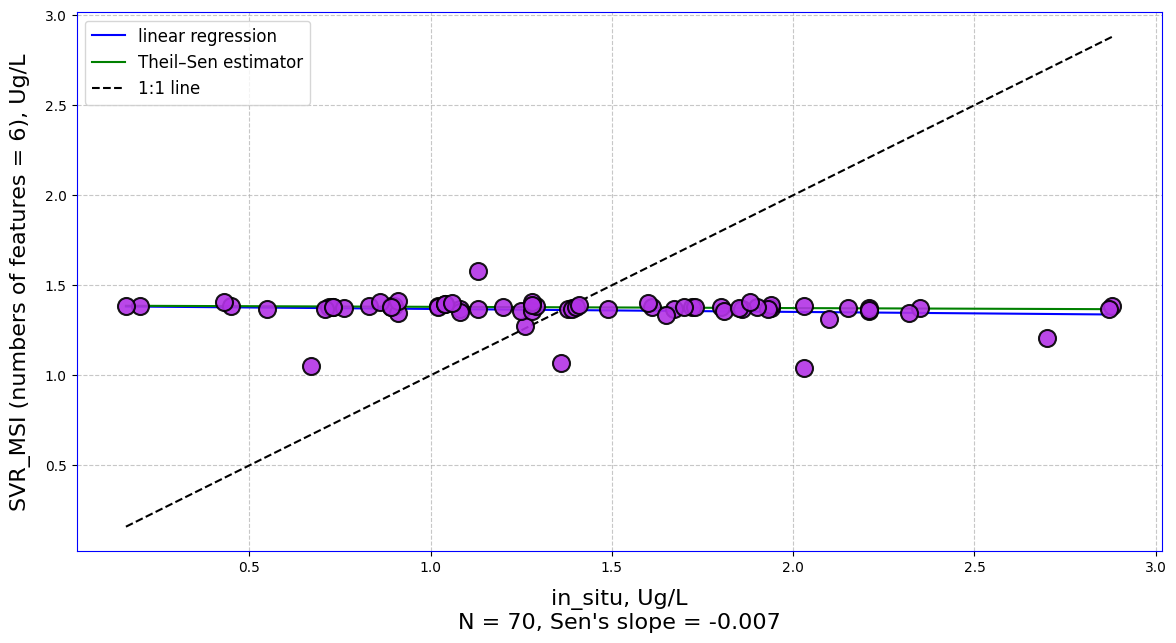

-0.6042361618375418
Cross-validated R^2: (0.00 + 0.19 + 0.08 + 0.05 + 0.00) / 5 = 0.07
Cross-validated Bias_log: (1.19 + 1.07 + 0.71 + 1.19 + 1.49) / 5 = 1.13
Cross-validated Bias: (-0.02 + 0.04 + 0.60 + -0.05 + -0.59) / 5 = -0.01
Cross-validated MAE_log: (1.63 + 1.47 + 1.74 + 1.48 + 1.64) / 5 = 1.59
Cross-validated MAE: (-0.53 + -0.49 + -0.84 + -0.40 + -0.71) / 5 = -0.59
Cross-validated RMSE: (-0.63 + -0.55 + -1.01 + -0.50 + -1.00) / 5 = -0.74
Cross-validated std: (-0.63 + -0.55 + -0.81 + -0.50 + -0.81) / 5 = -0.66
Cross-validated Sen's slope: (-2.69 + -39.71 + -0.77 + -4.25 + 0.00) / 5 = -9.48
Cross-validated MAPE: (-0.84 + -0.47 + -0.44 + -0.80 + -0.77) / 5 = -0.66

Hyperparams (fold number = 1): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 3): {'svr__C': np.float64(37.32892926643571), 'svr__epsilon

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_MSI (bands: Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6'], dtype='object'))",0.066445,1.130088,-0.00641,1.590585,0.593246,0.739571,0.660776,-9.48481,0.664048,70


In [58]:
df_msi_rrs6 = create_rrs_df_rgr(df_msi, dict_stats)
nested_cv(df_msi_rrs6, 'MSI', df_msi_rrs6.columns[:-1], param_grid, 'neg_root_mean_squared_error', SVR())

In [67]:
df_msi_rrs6_extra = create_rrs_df_rgr(
    df_msi, dict_stats, emp_algo_data={'oc3_msi': oreilly_data['oc3_msi'],
                   'li13': li_candidate_data['li13']})
# nested_cv(df_msi_rrs6_extra, 'MSI', df_msi_rrs6_extra.columns[:-1], param_grid, 'neg_root_mean_squared_error', SVR())

In [68]:
rf = RandomForestRegressor(random_state=42)
rf.fit(df_msi_rrs6_extra.iloc[:, :-1], df_msi_rrs6_extra['CHL'])
importance = pd.Series(rf.feature_importances_, index=df_msi_rrs6_extra.iloc[:, :-1].columns).sort_values(ascending=False)
top_features = importance.head(3).index.tolist()
nested_cv(df_msi_rrs6_extra, 'MSI', top_features, param_grid, 'neg_root_mean_squared_error', SVR())

KeyboardInterrupt: 

* лучшая

In [ ]:
nested_cv(df_msi_rrs6_extra, 'MSI', top_features, param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())    

Cross-validated R^2: (0.55 + 0.39 + 0.01 + 0.19 + 0.45) / 5 = 0.32
Cross-validated Bias_log: (0.82 + 1.10 + 0.87 + 1.11 + 1.45) / 5 = 1.07
Cross-validated Bias: (0.44 + -0.06 + 0.37 + -0.02 + -0.46) / 5 = 0.06
Cross-validated MAE_log: (1.42 + 1.32 + 1.50 + 1.47 + 1.47) / 5 = 1.44
Cross-validated MAE: (-0.52 + -0.35 + -0.71 + -0.40 + -0.47) / 5 = -0.49
Cross-validated RMSE: (-0.74 + -0.44 + -0.87 + -0.47 + -0.52) / 5 = -0.61
Cross-validated std: (-0.60 + -0.44 + -0.78 + -0.47 + -0.25) / 5 = -0.51
Cross-validated Sen's slope: (1.50 + 1.05 + 0.27 + 0.56 + 0.64) / 5 = 0.80
Cross-validated MAPE: (-0.32 + -0.38 + -0.40 + -0.48 + -0.50) / 5 = -0.41
Hyperparams (fold 1): {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 128}
Hyperparams (fold 2): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_spli

({'fit_time': array([9.42465377, 9.49329495, 9.76510048, 9.64119959, 9.39677429]),
  'score_time': array([0.00882483, 0.00485301, 0.00451922, 0.00952506, 0.00563431]),
  'estimator': [GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                          ('randomforestregressor',
                                           RandomForestRegressor())]),
                param_grid={'randomforestregressor__max_depth': [5, 10, 15],
                            'randomforestregressor__max_features': ['sqrt', 0.3],
                            'randomforestregressor__min_samples_split': [2, 5],
                            'randomforestregressor__n_estimators': [32, 64, 128]},
                return_train_score=True, scoring='neg_root_mean_squared_error'),
   GridSearchCV(cv=5,
                estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                          ('randomforestregressor',
     

In [ ]:
# results, best_model = nested_cv(
#     df_rrs=df_msi_rrs6_extra,
#     sensor="msi",
#     name_bands=top_features,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',
#     model=SVR(kernel='rbf'),
#     save_model=True
# )

# # Использование лучшей модели для предсказаний
# best_pipeline = best_model.best_estimator_

Model saved as SVR_msi.pkl
Cross-validated R^2: (0.44 + 0.15 + 0.00 + 0.26 + 0.16) / 5 = 0.20
Cross-validated Bias_log: (0.78 + 1.03 + 0.76 + 1.12 + 1.54) / 5 = 1.04
Cross-validated Bias: (0.15 + 0.05 + 0.55 + -0.02 + -0.53) / 5 = 0.04
Cross-validated MAE_log: (1.61 + 1.40 + 1.55 + 1.40 + 1.57) / 5 = 1.51
Cross-validated MAE: (-0.37 + -0.42 + -0.73 + -0.35 + -0.57) / 5 = -0.49
Cross-validated RMSE: (-0.49 + -0.51 + -0.89 + -0.44 + -0.61) / 5 = -0.59
Cross-validated std: (-0.47 + -0.51 + -0.70 + -0.44 + -0.31) / 5 = -0.49
Cross-validated Sen's slope: (0.72 + 0.86 + -0.42 + 1.15 + -0.26) / 5 = 0.41
Cross-validated MAPE: (-0.45 + -0.40 + -0.38 + -0.43 + -0.61) / 5 = -0.45
Hyperparams (fold 1): {'svr__C': np.float64(37.32892926643571), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.026788874464158525)}
Hyperparams (fold 2): {'svr__C': np.float64(0.9258747122872903), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.125)}
Hyperparams (fold 3): {'svr__C': np.float64(1.7144879657061456), 'svr_

AttributeError: 'Pipeline' object has no attribute 'best_estimator_'

```java
var rfRegressor = ee.Classifier.smileRandomForest({
  numberOfTrees: 64,          // Среднее значение из CV
  variablesPerSplit: 1,       // Для 3 признаков: sqrt(3) ≈ 1.7 → округляем до 1
  minLeafPopulation: 5,       // Наиболее частый выбор в CV
  seed: 42,                   // Для воспроизводимости
  maxNodes: 32                // Ограничение сложности (аналог max_depth≈5)
}).setOutputMode('REGRESSION');

### bootstrap

In [62]:
def caledonia(model, n_resamples: int, df_rrs: pd.DataFrame) -> list:
    """_summary_

    Args:
        model: not trained
        df_rrs (pd.DataFrame): columns[-2] == CHL

    Returns:
        pd.DataFrame: RMSE + Sen's slope (mean, confidence interaval, Kruskal test) for each models
    """

    df_result = pd.DataFrame()
    all_features = list(
        itertools.chain.from_iterable(itertools.combinations(
            df_rrs.columns[:-1], r) for r in range(1, 7))
    )
    np.random.seed(42)
    bootstrap_samples_keys = np.random.choice(
        df_rrs.index, (n_resamples, df_rrs.shape[0]), replace=True)
    rmse_dict, sens_slope_dict = dict(), dict()
    keys, number_of_bands_dict = dict(), dict()
    rmse_full_dict, sens_slope_full_dict = dict(), dict()
    rmse_ci_dict, sens_slope_ci_dict = dict(), dict()

    for combo_idx, combo in enumerate(all_features):
        rmse_bs_current, sens_slope_bs_current = np.zeros(
            n_resamples, dtype=np.float64), np.zeros(n_resamples, dtype=np.float64)
        number_of_bands_dict[combo_idx] = len(combo)

        # ---
        df_full = df_rrs.loc[:, combo].join(df_rrs['CHL'])
        X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
            df_full.iloc[:, :-1], df_full['CHL'],
            test_size=30, random_state=42
        )
        pipe_full = make_pipeline(StandardScaler(), model())
        pipe_full.fit(X_train_full, y_train_full)
        y_pred_full = pipe_full.predict(X_test_full)
        rmse_full_dict[combo_idx] = np.sqrt(
            mean_squared_error(y_test_full, y_pred_full))
        sens_slope_full_dict[combo_idx] = theilslopes(
            y_pred_full, y_test_full).slope
        # ---

        for i, indecies_current in enumerate(bootstrap_samples_keys):
            df_current = df_rrs.loc[indecies_current,
                                    combo].join(df_rrs['CHL'])
            X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(
                df_current.iloc[:, :-1], df_current['CHL'], test_size=30, random_state=42)
            pipe = make_pipeline(StandardScaler(), model())
            pipe.fit(X_train_current, y_train_current)
            y_pred_current = pipe.predict(X_test_current)
            rmse_bs_current[i], sens_slope_bs_current[i] = np.sqrt(mean_squared_error(
                y_pred_current, y_test_current)), theilslopes(y_pred_current, y_test_current).slope
        
        rmse_ci_dict[combo_idx] = (_s1 := sorted(rmse_bs_current))[-2] - _s1[1]
        sens_slope_ci_dict[combo_idx] = (_s2 := sorted(sens_slope_bs_current))[-2] - _s2[1]
        rmse_dict[combo_idx], sens_slope_dict[combo_idx] = rmse_bs_current.mean(
        ), sens_slope_bs_current.mean()
        keys[combo_idx] = combo

    df_result['Number of used bands'] = number_of_bands_dict

    df_result['RMSE initial'] = rmse_full_dict
    df_result['RMSE mean'] = rmse_dict
    df_result['RMSE CI Length'] = rmse_ci_dict

    df_result['Sen\'s slope initial'] = sens_slope_full_dict
    df_result['Sen\'s slope mean'] = sens_slope_dict
    df_result['Sen\'s slope CI Length'] = sens_slope_ci_dict

    return df_result, keys

In [63]:
bs_result_msi = caledonia(SVR, 50, create_rrs_df_rgr(df_msi, dict_stats))

In [64]:
bs_result_msi[0].describe()

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,3.047619,0.495612,0.616138,0.360871,0.013599,0.028163,0.145827
std,1.183605,0.003754,0.001803,0.010615,0.005080,0.002938,0.012263
min,1.000000,0.488219,0.611877,0.319296,0.002567,0.019044,0.122667
25%,2.000000,0.493946,0.614820,0.353976,0.010412,0.025937,0.137573
50%,3.000000,0.495017,0.615903,0.360378,0.013911,0.028533,0.143039
75%,4.000000,0.497038,0.616769,0.368964,0.017189,0.029740,0.155450
max,6.000000,0.519654,0.620876,0.376229,0.026262,0.035520,0.174934


In [65]:
bs_result_msi[0].sort_values('RMSE mean').head(10) # 11, 31, 21

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
2,1,0.519654,0.611877,0.355298,0.003294,0.035520,0.157446
11,2,0.498635,0.613154,0.353909,0.020937,0.032218,0.148719
31,3,0.497308,0.613791,0.362441,0.021791,0.031068,0.153252
32,3,0.499115,0.613816,0.363248,0.018791,0.032179,0.171493
33,3,0.497260,0.613930,0.364005,0.015931,0.032212,0.174934
15,2,0.496989,0.614144,0.367694,0.022783,0.033414,0.172847
16,2,0.499190,0.614156,0.369387,0.018126,0.033214,0.150843
7,2,0.493889,0.614216,0.339077,0.018280,0.030912,0.143726
21,3,0.494339,0.614241,0.344068,0.018095,0.028960,0.138012
41,4,0.494242,0.614325,0.353015,0.017476,0.029000,0.136007


In [66]:
bs_result_msi[0].sort_values('RMSE CI Length').head(10)

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
0,1,0.488219,0.620876,0.319296,0.006942,0.019044,0.124930
6,2,0.491444,0.616304,0.339064,0.014723,0.023238,0.129970
7,2,0.493889,0.614216,0.339077,0.018280,0.030912,0.143726
21,3,0.494339,0.614241,0.344068,0.018095,0.028960,0.138012
10,2,0.491845,0.619488,0.344855,0.003419,0.023367,0.142474
9,2,0.492804,0.618540,0.345565,0.011127,0.024543,0.143303
8,2,0.490842,0.618034,0.348331,0.014497,0.024940,0.129108
22,3,0.492351,0.615757,0.352523,0.016901,0.025342,0.128376
27,3,0.493924,0.615393,0.353006,0.015557,0.029806,0.143414
41,4,0.494242,0.614325,0.353015,0.017476,0.029000,0.136007


In [67]:
bs_result_msi[0].sort_values('RMSE CI Length').loc[[11, 31, 21], :]

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
11,2,0.498635,0.613154,0.353909,0.020937,0.032218,0.148719
31,3,0.497308,0.613791,0.362441,0.021791,0.031068,0.153252
21,3,0.494339,0.614241,0.344068,0.018095,0.028960,0.138012


In [68]:
___ = create_rrs_df_rgr(df_msi, dict_stats)

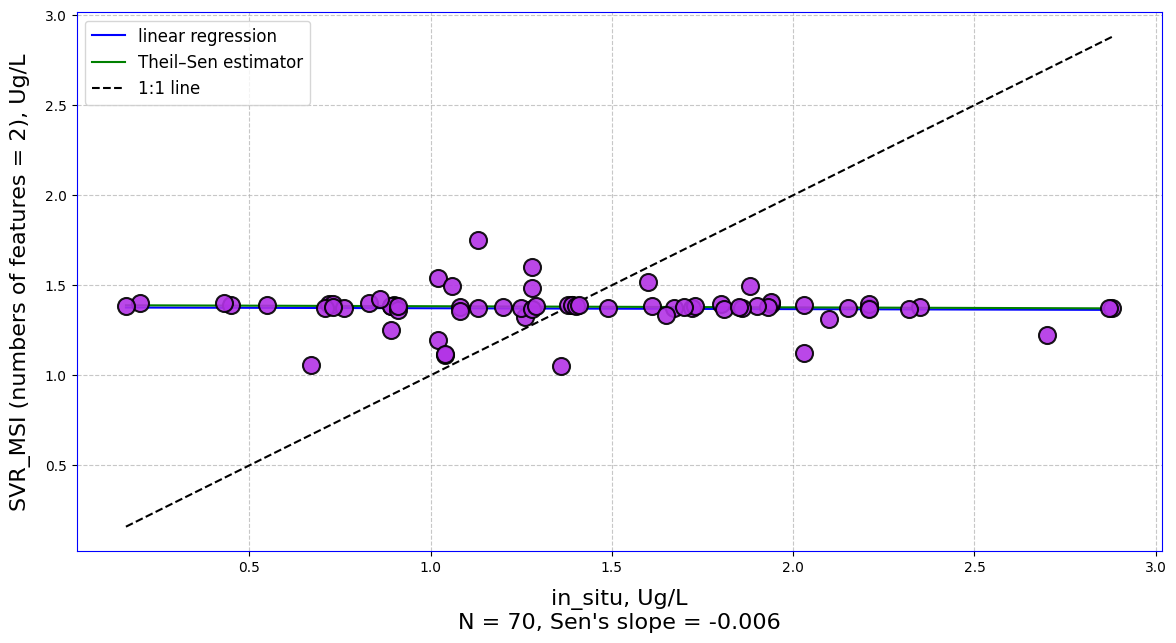

-0.6016979157244212
Cross-validated R^2: (0.01 + 0.15 + 0.01 + 0.05 + 0.04) / 5 = 0.05
Cross-validated Bias_log: (1.19 + 1.07 + 0.77 + 1.19 + 1.30) / 5 = 1.11
Cross-validated Bias: (-0.02 + 0.03 + 0.53 + -0.05 + -0.39) / 5 = 0.02
Cross-validated MAE_log: (1.63 + 1.47 + 1.56 + 1.48 + 1.52) / 5 = 1.53
Cross-validated MAE: (-0.53 + -0.49 + -0.73 + -0.40 + -0.54) / 5 = -0.54
Cross-validated RMSE: (-0.63 + -0.55 + -0.88 + -0.50 + -0.81) / 5 = -0.67
Cross-validated std: (-0.63 + -0.55 + -0.70 + -0.50 + -0.71) / 5 = -0.62
Cross-validated Sen's slope: (-5.92 + -32.67 + 2.01 + -1.48 + 0.22) / 5 = -7.57
Cross-validated MAPE: (-0.83 + -0.47 + -0.38 + -0.80 + -0.59) / 5 = -0.62

Hyperparams (fold number = 1): {'svr__C': np.float64(1.7144879657061456), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.026788874464158525)}
Hyperparams (fold number = 3): {'svr__C': np.float6

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_MSI (bands: ('B2', 'B3'))",0.049469,1.106486,0.019148,1.529723,0.538405,0.673343,0.617566,-7.568011,0.615993,70


In [69]:
nested_cv(___, 'MSI', bs_result_msi[1][11], param_grid, 'neg_root_mean_squared_error', SVR())

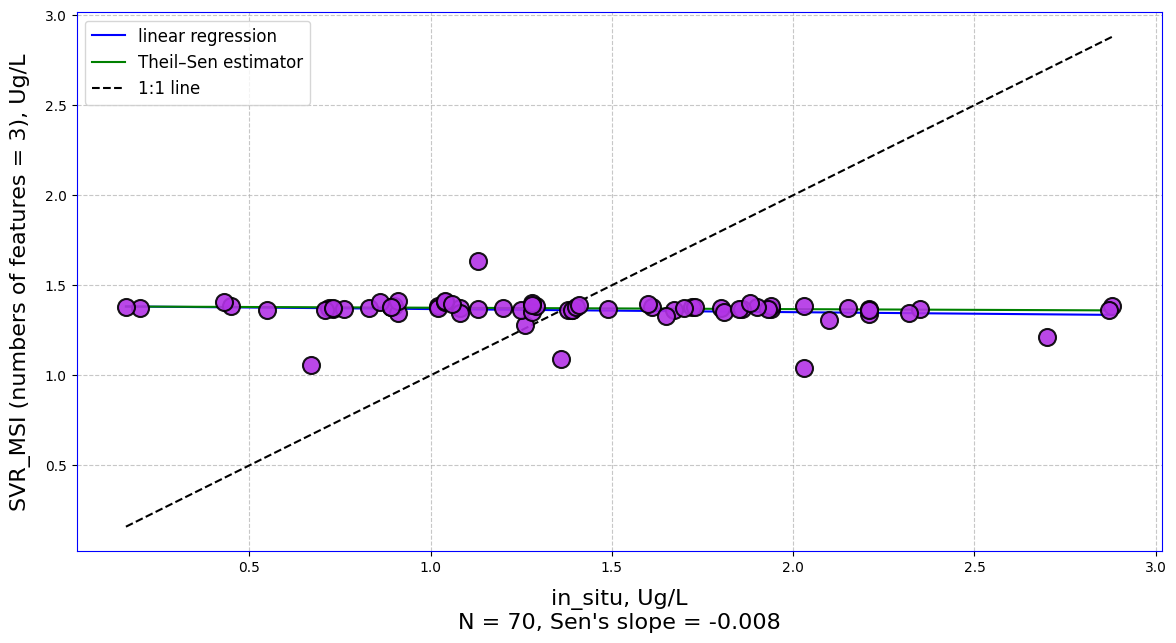

-0.6052000421541953
Cross-validated R^2: (0.00 + 0.12 + 0.01 + 0.05 + 0.05) / 5 = 0.04
Cross-validated Bias_log: (1.19 + 1.06 + 0.77 + 1.19 + 1.34) / 5 = 1.11
Cross-validated Bias: (-0.02 + 0.05 + 0.53 + -0.05 + -0.37) / 5 = 0.03
Cross-validated MAE_log: (1.63 + 1.47 + 1.55 + 1.48 + 1.52) / 5 = 1.53
Cross-validated MAE: (-0.53 + -0.49 + -0.73 + -0.40 + -0.50) / 5 = -0.53
Cross-validated RMSE: (-0.63 + -0.55 + -0.88 + -0.50 + -0.58) / 5 = -0.63
Cross-validated std: (-0.63 + -0.55 + -0.70 + -0.50 + -0.45) / 5 = -0.57
Cross-validated Sen's slope: (-5.19 + -24.23 + 1.22 + -3.62 + 0.21) / 5 = -6.32
Cross-validated MAPE: (-0.83 + -0.47 + -0.38 + -0.80 + -0.57) / 5 = -0.61

Hyperparams (fold number = 1): {'svr__C': np.float64(0.9258747122872903), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 3): {'svr__C': np.float6

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_MSI (bands: ('B1', 'B2', 'B3'))",0.04407,1.111791,0.0273,1.530731,0.529661,0.628093,0.565048,-6.32208,0.610051,70


In [70]:
nested_cv(___, 'MSI', bs_result_msi[1][21], param_grid, 'neg_root_mean_squared_error', SVR())

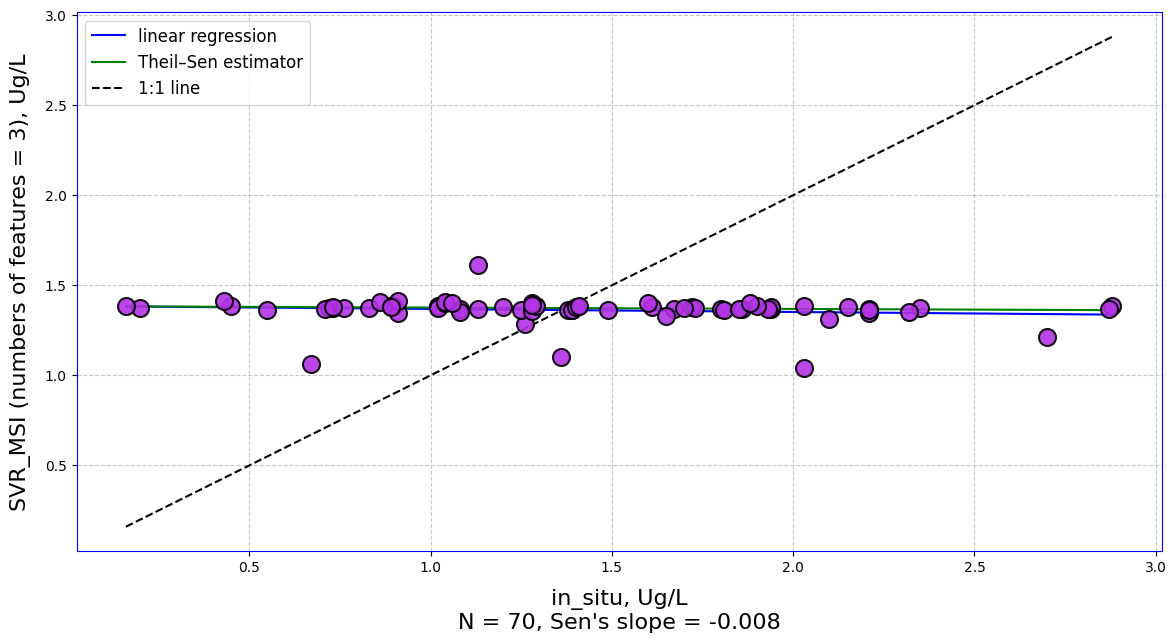

-0.6045879973159146
Cross-validated R^2: (0.00 + 0.19 + 0.01 + 0.05 + 0.06) / 5 = 0.06
Cross-validated Bias_log: (1.19 + 1.06 + 0.78 + 1.19 + 1.35) / 5 = 1.11
Cross-validated Bias: (-0.02 + 0.05 + 0.52 + -0.05 + -0.37) / 5 = 0.02
Cross-validated MAE_log: (1.63 + 1.47 + 1.56 + 1.48 + 1.48) / 5 = 1.53
Cross-validated MAE: (-0.53 + -0.49 + -0.74 + -0.40 + -0.48) / 5 = -0.53
Cross-validated RMSE: (-0.63 + -0.55 + -0.88 + -0.50 + -0.59) / 5 = -0.63
Cross-validated std: (-0.63 + -0.55 + -0.71 + -0.50 + -0.46) / 5 = -0.57
Cross-validated Sen's slope: (-4.10 + -47.30 + -0.65 + -4.44 + 0.20) / 5 = -11.26
Cross-validated MAPE: (-0.83 + -0.47 + -0.39 + -0.80 + -0.54) / 5 = -0.61

Hyperparams (fold number = 1): {'svr__C': np.float64(0.9258747122872903), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 3): {'svr__C': np.floa

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_MSI (bands: ('B2', 'B3', 'B4'))",0.061779,1.114673,0.023884,1.525296,0.527293,0.629737,0.567716,-11.257918,0.606791,70


In [71]:
nested_cv(___, 'MSI', bs_result_msi[1][31], param_grid, 'neg_root_mean_squared_error', SVR())

## RF

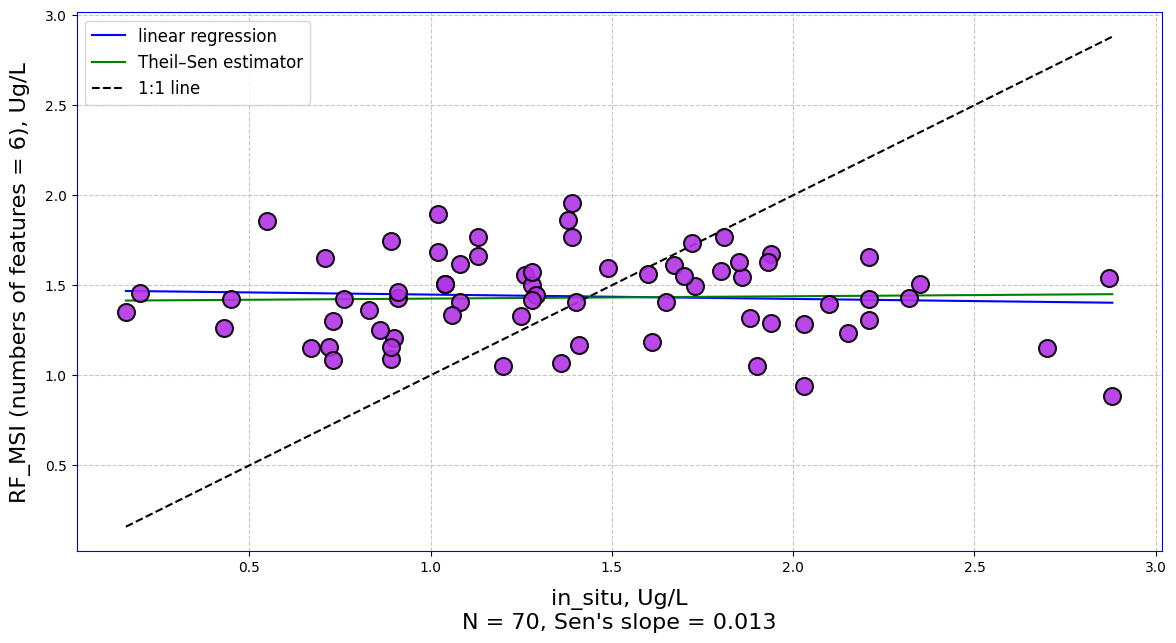

-0.6258496421802875
Cross-validated R^2: (0.01 + 0.03 + 0.20 + 0.22 + 0.01) / 5 = 0.09
Cross-validated Bias_log: (1.29 + 0.95 + 0.77 + 1.29 + 1.46) / 5 = 1.15
Cross-validated Bias: (-0.16 + 0.16 + 0.52 + -0.17 + -0.45) / 5 = -0.02
Cross-validated MAE_log: (1.66 + 1.45 + 1.64 + 1.45 + 1.54) / 5 = 1.55
Cross-validated MAE: (-0.57 + -0.47 + -0.79 + -0.37 + -0.54) / 5 = -0.55
Cross-validated RMSE: (-0.68 + -0.59 + -0.97 + -0.48 + -0.61) / 5 = -0.67
Cross-validated std: (-0.66 + -0.57 + -0.82 + -0.45 + -0.40) / 5 = -0.58
Cross-validated Sen's slope: (0.06 + 0.50 + -1.29 + 1.25 + 0.17) / 5 = 0.14
Cross-validated MAPE: (-0.93 + -0.43 + -0.42 + -0.79 + -0.58) / 5 = -0.63

Hyperparams (fold number = 1): {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.3, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 32}
Hyperparams (fold number = 2): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.3, 'rando

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"RF_MSI (bands: Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6'], dtype='object'))",0.094598,1.149893,-0.019325,1.547116,0.546641,0.666409,0.580811,0.136229,0.629755,70


In [72]:
_ = create_rrs_df_rgr(df_msi, dict_stats)
nested_cv(_, 'MSI', _.columns[:-1], param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())

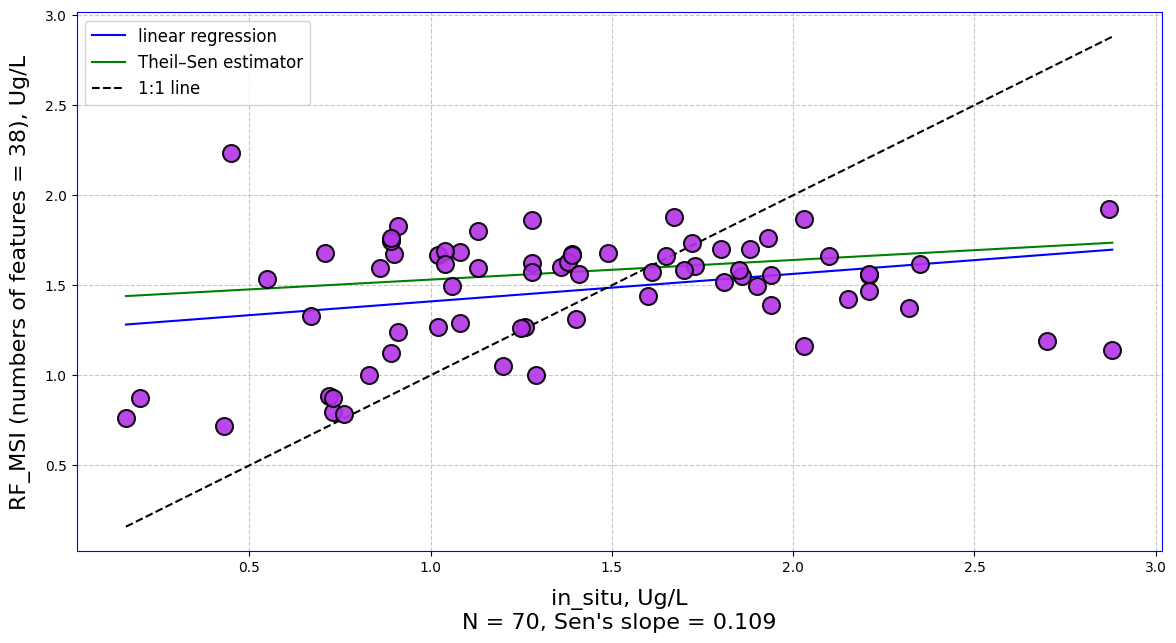

-0.559349503231526
Cross-validated R^2: (0.51 + 0.01 + 0.01 + 0.44 + 0.12) / 5 = 0.22
Cross-validated Bias_log: (1.19 + 1.21 + 0.78 + 1.22 + 1.49) / 5 = 1.18
Cross-validated Bias: (-0.07 + -0.18 + 0.50 + -0.11 + -0.48) / 5 = -0.07
Cross-validated MAE_log: (1.40 + 1.40 + 1.57 + 1.43 + 1.54) / 5 = 1.47
Cross-validated MAE: (-0.36 + -0.44 + -0.73 + -0.36 + -0.54) / 5 = -0.49
Cross-validated RMSE: (-0.45 + -0.62 + -0.91 + -0.40 + -0.59) / 5 = -0.59
Cross-validated std: (-0.44 + -0.59 + -0.77 + -0.39 + -0.34) / 5 = -0.51
Cross-validated Sen's slope: (0.97 + 0.25 + -0.69 + 1.27 + 0.27) / 5 = 0.41
Cross-validated MAPE: (-0.52 + -0.54 + -0.38 + -0.57 + -0.57) / 5 = -0.52

Hyperparams (fold number = 1): {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.3, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 128}
Hyperparams (fold number = 2): {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 'sqrt', '

,R^2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"RF_MSI (bands: Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B1/B2', 'B1/B3', 'B1/B4', 'B1/B5',\n 'B1/B6', 'B2/B1', 'B2/B3', 'B2/B4', 'B2/B5', 'B2/B6', 'B3/B1', 'B3/B2',\n 'B3/B4', 'B3/B5', 'B3/B6', 'B4/B1', 'B4/B2', 'B4/B3', 'B4/B5', 'B4/B6',\n 'B5/B1', 'B5/B2', 'B5/B3', 'B5/B4', 'B5/B6', 'B6/B1', 'B6/B2', 'B6/B3',\n 'B6/B4', 'B6/B5', 'oc3_msi', 'li13'],\n dtype='object'))",0.216803,1.176949,-0.069017,1.467832,0.486618,0.594848,0.50611,0.413211,0.515889,70


In [74]:
__ = create_rrs_df_rgr(
    df_msi, dict_stats,
    emp_algo_data={'oc3_msi': oreilly_data['oc3_msi'],
                   'li13': li_candidate_data['li13']}
)
nested_cv(__, 'MSI', __.columns[:-1], param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())

# best model

In [71]:
import streamlit as st
import geemap.foliumap as geemap

In [ ]:
C_range = np.logspace(-1, 7, 10, base=2)
gamma_range = np.logspace(-7, -3, 10, base=2)
param_grid = dict(svr__gamma=gamma_range, svr__C=C_range, svr__epsilon=[0.1, 0.01])

df_msi_rrs6_extra = create_rrs_df_rgr(
    df_msi, dict_stats, emp_algo_data={'oc3_msi': oreilly_data['oc3_msi'],
                   'li13': li_candidate_data['li13']})
rf = RandomForestRegressor(random_state=42)
rf.fit(df_msi_rrs6_extra.iloc[:, :-1], df_msi_rrs6_extra['CHL'])
importance = pd.Series(rf.feature_importances_, index=df_msi_rrs6_extra.iloc[:, :-1].columns).sort_values(ascending=False)
top_features = importance.head(3).index.tolist()

model = make_pipeline(StandardScaler(), SVR())
grid = GridSearchCV(model, param_grid, cv=5, refit=True)
grid.fit(df_msi_rrs6_extra.iloc[:, :-1], df_msi_rrs6_extra['CHL'])
joblib.dump(grid.best_estimator_, 'final_model_msi.pkl')

In [67]:
def calculate_oc3(image):
    # Выбираем нужные каналы: B1, B2, B3
    B1 = image.select('B1')
    B2 = image.select('B2')
    B3 = image.select('B3')
    
    # Вычисляем max(B1, B2)
    max_B1_B2 = B1.max(B2)
    
    # Вычисляем R = max(B1, B2) / B3
    R = max_B1_B2.divide(B3)
    
    # Вычисляем log10(R)
    logR = R.log10()
    
    # Вычисляем полиномиальные члены
    R2 = logR.pow(2)
    R3 = logR.pow(3)
    R4 = logR.pow(4)
    
    # Вычисляем OC3 по формуле
    oc3 = ee.Image(0.30963) \
        .subtract(logR.multiply(2.40052)) \
        .add(R2.multiply(1.28932)) \
        .add(R3.multiply(0.52802)) \
        .subtract(R4.multiply(1.33825)) \
        .exp() \
        .multiply(10)  # 10^expression
    
    return image.addBands(oc3.rename('oc3_msi'))

In [65]:
model = joblib.load('final_model_msi.pkl')

# Параметры
START_DATE = '2018-05-01'
END_DATE = '2018-05-30'
LAKE_SHAPEFILE = 'projects/ee-airgit1/assets/baikal_shape'

In [ ]:
def calculate_oc3(image):
    # Выбираем нужные каналы: B1, B2, B3
    B1 = image.select('B1')
    B2 = image.select('B2')
    B3 = image.select('B3')
    
    # Вычисляем max(B1, B2)
    max_B1_B2 = B1.max(B2)
    
    # Вычисляем R = max(B1, B2) / B3
    R = max_B1_B2.divide(B3)
    
    # Вычисляем log10(R)
    logR = R.log10()
    
    # Вычисляем полиномиальные члены
    R2 = logR.pow(2)
    R3 = logR.pow(3)
    R4 = logR.pow(4)
    
    # Вычисляем OC3 по формуле
    oc3 = ee.Image(0.30963) \
        .subtract(logR.multiply(2.40052)) \
        .add(R2.multiply(1.28932)) \
        .add(R3.multiply(0.52802)) \
        .subtract(R4.multiply(1.33825)) \
        .exp() \
        .multiply(10)  # 10^expression
    
    return image.addBands(oc3.rename('oc3_msi'))


lake_geom = ee.FeatureCollection(LAKE_SHAPEFILE).geometry()

# Коллекция изображений
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate(START_DATE, END_DATE)
    .filterBounds(lake_geom)
    .map(scale_msi)
    .map(mask_S2_clouds)
    .map(calculate_oc3)
)

# Медианное усреднение
median_image = collection.median().clip(lake_geom)

# Расчет признаков
features_image = median_image.expression(
    "return [B2/B3, oc3, B3/B2];",
    {
        'B2': median_image.select('B2'),
        'B3': median_image.select('B3'),
        'oc3': median_image.select('oc3_msi')
    }
).rename(['B2/B3', 'oc3_msi', 'B3/B2'])

In [70]:
task = ee.batch.Export.image.toDrive(
    image=features_image,
    description='Chl_Features_Export',
    scale=10,
    region=lake_geom,
    fileFormat='GeoTIFF',
    maxPixels=1e13
)
task.start()

EEException: Request had insufficient authentication scopes.

In [ ]:
def create_rrs_df_rgr(df, dict_os_bands, emp_algo_data=None, mode=0):
    dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
    df_rrs = None
    col = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A'] \
        if mode else ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
    df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
        .loc[:, col]
                
    indecies_set = set()            
    for column in df_rrs.columns:
        result = hampel(df_rrs[column])
        
        # Преобразование индексов выбросов в метки строк из in_situ
        outlier_indices = list(map(lambda t: df_rrs.index[t], result.outlier_indices))
        
        indecies_set.update(outlier_indices)
    
    df_rrs_cleaned = copy.deepcopy(df_rrs).drop(list(indecies_set))
    if emp_algo_data:
        for numerator, denominator in itertools.permutations(df_rrs_cleaned.columns, 2):
            ratio_name = f"{numerator}/{denominator}"
            df_rrs_cleaned[ratio_name] = df_rrs_cleaned[numerator] / df_rrs[denominator]
        for k, v in emp_algo_data.items():
            _t = pd.Series(v[-1])
            _t.name = k
            df_rrs_cleaned = df_rrs_cleaned.join(_t)
    
    # df_rrs_cleaned['2B1'] = df_rrs_cleaned['B6'] / df_rrs_cleaned['B5']
    # df_rrs_cleaned['2B2'] = df_rrs_cleaned['B5'] / df_rrs_cleaned['B4']
    # df_rrs_cleaned['NDCI'] = (df_rrs_cleaned['B5'] - df_rrs_cleaned['B4']) / (df_rrs_cleaned['B5'] + df_rrs_cleaned['B4'])
    # df_rrs_cleaned['3B'] = (1 / df_rrs_cleaned['B4'] - 1 / df_rrs_cleaned['B5']) * df_rrs_cleaned['B6']
    return df_rrs_cleaned.join(df.loc[:, 'CHL'])

In [64]:
top_features

['B2/B3', 'oc3_msi', 'B3/B2']

In [ ]:
C_range = np.logspace(-1, 7, 10, base=2)
gamma_range = np.logspace(-7, -3, 10, base=2)
param_grid = dict(svr__gamma=gamma_range, svr__C=C_range, svr__epsilon=[0.1, 0.01])

df_msi_rrs6_extra = create_rrs_df_rgr(
    df_msi, dict_stats, emp_algo_data={'oc3_msi': oreilly_data['oc3_msi'],
                   'li13': li_candidate_data['li13']})
rf = RandomForestRegressor(random_state=42)
rf.fit(df_msi_rrs6_extra.iloc[:, :-1], df_msi_rrs6_extra['CHL'])
importance = pd.Series(rf.feature_importances_, index=df_msi_rrs6_extra.iloc[:, :-1].columns).sort_values(ascending=False)
top_features = importance.head(3).index.tolist()

model = make_pipeline(StandardScaler(), SVR())
grid = GridSearchCV(model, param_grid, cv=5, refit=True)
grid.fit(df_msi_rrs6_extra.iloc[:, :-1], df_msi_rrs6_extra['CHL'])
joblib.dump(grid.best_estimator_, 'final_model_msi.pkl')

In [62]:
svr = grid.best_estimator_.named_steps['svr']

# Для RBF ядра:
print("Support vectors:", svr.support_vectors_)
print("Dual coefficients:", svr.dual_coef_)
print("Intercept:", svr.intercept_)
print("Gamma:", svr.gamma)

Support vectors: [[ 2.17067583  1.11333467  1.47877141 ...  1.00246217 -0.68333968
   1.99994424]
 [-0.47542652 -0.46638539 -0.50894201 ...  0.77086    -1.30472354
  -1.78010115]
 [-0.46586517 -0.46467389 -0.49887068 ... -0.9094254  -1.18267462
  -1.51847417]
 ...
 [-0.12484385 -0.13948774 -0.13996526 ...  0.41670149  0.05869853
   0.2376866 ]
 [-0.11528251 -0.17714087 -0.20863339 ...  0.50111519 -0.6224964
  -0.18126301]
 [-0.20133462 -0.16344883 -0.22053587 ...  0.26301255 -0.17699159
  -0.44697368]]
Dual coefficients: [[ 0.20503093 -0.5         0.04710481 -0.5         0.5         0.5
  -0.5         0.5         0.5         0.5         0.5        -0.5
  -0.5         0.1526771  -0.5         0.5        -0.08344632  0.5
   0.09516321  0.5         0.5         0.5        -0.5        -0.5
  -0.5        -0.5         0.5         0.5         0.5         0.5
   0.5         0.5        -0.5         0.5        -0.5        -0.5
  -0.5         0.5         0.5        -0.5         0.5         0.5
   0

In [63]:
import json

# Сохраняем метаданные модели
model_metadata = {
    "sensor": "Sentinel-2",
    "bands": ["B3", "B4", "B8"],
    "best_params": grid.best_params_,
    "scaling_params": {
        "mean": grid.best_estimator_.named_steps['standardscaler'].mean_.tolist(),
        "scale": grid.best_estimator_.named_steps['standardscaler'].scale_.tolist()
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f)

```python
import streamlit as st
import ee
import json
import requests
from datetime import date
import geemap.foliumap as geemap

# Инициализация GEE
ee.Initialize()

# Загрузка параметров модели
MODEL_URL = "https://drive.google.com/uc?export=download&id=YOUR_MODEL_ID"
model_params = json.loads(requests.get(MODEL_URL).text)['features'][0]['properties']

# Функция создания модели из параметров
def create_model(params):
    return ee.Classifier.decisionTreeEnsemble(params).setOutputMode('REGRESSION')

# Загрузка формы озера
LAKE_SHAPE = ee.FeatureCollection("users/your_lake_shapefile").geometry()

# UI
st.title("Мониторинг хлорофилла-а")
st.sidebar.header("Параметры")

with st.sidebar:
    date_range = st.date_input(
        "Диапазон дат",
        [date(2023, 6, 1), date(2023, 6, 30)]
    )
    sensor = st.selectbox("Сенсор", ["Sentinel-2 MSI", "Landsat 8-9 OLI"])
    cloud_threshold = st.slider("Макс. облачность (%)", 0, 100, 20)

# Функция обработки изображений
def process_image(start_date, end_date, sensor):
    if sensor == "Sentinel-2 MSI":
        col = ee.ImageCollection('COPERNICUS/S2_SR')
    else:
        col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    
    img = col.filterDate(start_date, end_date) \
            .filterBounds(LAKE_SHAPE) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_threshold)) \
            .median() \
            .clip(LAKE_SHAPE)
    
    # Рассчет NDWI
    if sensor == "Sentinel-2 MSI":
        ndwi = img.normalizedDifference(['B3', 'B8'])
    else:
        ndwi = img.normalizedDifference(['SR_B3', 'SR_B5'])
    
    return img.addBands(ndwi.rename('NDWI'))

# Создание карты
m = geemap.Map()
m.centerObject(LAKE_SHAPE, 10)

if st.button("Сгенерировать картограмму"):
    with st.spinner("Обработка данных..."):
        # Получение изображения
        image = process_image(
            start_date=str(date_range[0]),
            end_date=str(date_range[1]),
            sensor=sensor
        )
        
        # Применение модели
        model = create_model(model_params)
        chla = image.select(['B2', 'B3', 'NDWI']) \
                   .classify(model, 'chla') \
                   .clip(LAKE_SHAPE)
        
        # Визуализация
        vis_params = {
            'min': 0.5,
            'max': 30,
            'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
        }
        
        m.addLayer(chla, vis_params, "Хлорофилл-а (μg/L)")
        m.add_colorbar(vis_params, label="Хлорофилл-а, μg/L")
        
        # Статистика по озеру
        stats = chla.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=LAKE_SHAPE,
            scale=100
        ).getInfo()
        
        st.success(f"Средняя концентрация: {stats.get('chla', 0):.2f} μg/L")

m.to_streamlit(height=600)

# Classifier

In [76]:
with open("supplement/data_sent2_all.pickle", "rb") as file:
    dict_stats = pickle.load(file)

In [77]:
df_all = copy.deepcopy(_df_all)
df_msi = df_all.loc[pd.Index(dict_stats.keys())]

Train Accuracy: 0.9841269841269841       Test Accuracy: 0.8666666666666667
F1 Score Train: 0.6666666666666666
F1 Score Test: 0.0


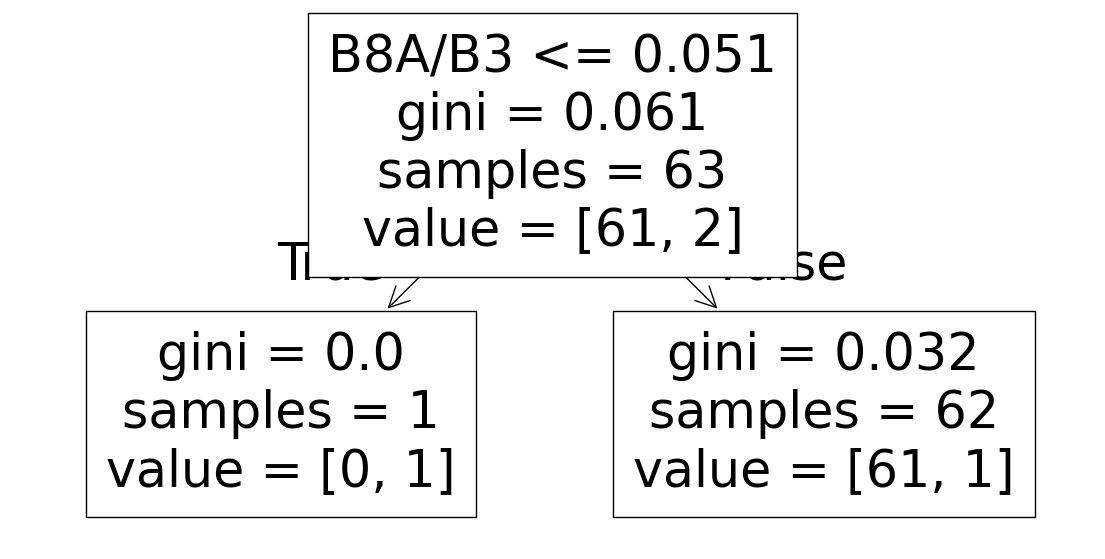

In [89]:
def create_rrs_df_clf(df: pd.DataFrame, dict_os_bands: dict, sensor: str, mode: int = 0, extra_feat: int = 0) -> pd.DataFrame:
    """_summary_

    Args:
        df (pd.DataFrame): _description_
        dict_os_bands (dict): _description_
        sensor (str): _description_
        mode (int, optional): 0 is 6 bands, 1 is all bands. Defaults to 0.
        extra_feat (int, optional): 0 is nothing, 1 is add combinations pf features. Defaults to 0.

    Returns:
        pd.DataFrame: df_rrs + column of type of water
    """
    
    dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
    df_rrs = None
    match sensor:
        case 'msi':
            col = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A']
            df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
                .loc[:, col]
                
    if extra_feat:
        for numerator, denominator in itertools.permutations(df_rrs.columns, 2):
            ratio_name = f"{numerator}/{denominator}"
            df_rrs[ratio_name] = df_rrs[numerator] / df_rrs[denominator]
    
    return df_rrs.join(df['type_water'])


df_msi['type_water'] = df_msi['CHL'].apply(lambda x: 1 if x > THRESHOLD else 0)

df_rrs10_classif_extra = create_rrs_df_clf(df_msi, dict_stats, 'msi', mode=1, extra_feat=1)

selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected_extra = selector.fit_transform(df_rrs10_classif_extra.iloc[:, :-1], df_rrs10_classif_extra['type_water'])

X_train_own_extra, X_test_own_extra, y_train_own_extra, y_test_own_extra = train_test_split(X_selected_extra, df_rrs10_classif_extra['type_water'],
                                                                        test_size=30, stratify=df_rrs10_classif_extra['type_water'], random_state=42)
tree_model_mod4_own = tree.DecisionTreeClassifier(max_depth=1, random_state=42).fit(X_train_own_extra, y_train_own_extra)
selected_features_mod4_own = list(map(lambda x: df_rrs10_classif_extra.columns[x], selector.get_support(indices=True)))

tree.plot_tree(tree_model_mod4_own, feature_names=selected_features_mod4_own)

print(f"Train Accuracy: {tree_model_mod4_own.score(X_train_own_extra, y_train_own_extra)} \
      Test Accuracy: {tree_model_mod4_own.score(X_test_own_extra, y_test_own_extra)}")
print(f"F1 Score Train: {f1_score(y_train_own_extra, tree_model_mod4_own.predict(X_train_own_extra))}")
print(f"F1 Score Test: {f1_score(y_test_own_extra, tree_model_mod4_own.predict(X_test_own_extra))}")

Классификация никакая из-за дисбаланса. Потом подумать, либо на будущее

In [90]:
svc_model = SVC(kernel='linear', random_state=42, probability=True).fit(X_train_own_extra, y_train_own_extra)

# Вывод точности на тренировочных и тестовых данных
print(f"Train Accuracy: {svc_model.score(X_train_own_extra, y_train_own_extra):.4f} \
      Test Accuracy: {svc_model.score(X_test_own_extra, y_test_own_extra):.4f}")
print(f"F1 Score Train: {f1_score(y_train_own_extra, svc_model.predict(X_train_own_extra))}")
print(f"F1 Score Test: {f1_score(y_test_own_extra, svc_model.predict(X_test_own_extra))}")

# Отбор важных признаков на основе коэффициентов модели
selector = SelectFromModel(estimator=svc_model, threshold="median")
selector.fit(X_train_own_extra, y_train_own_extra)

# Получение названий выбранных признаков
selected_features = list(map(lambda x: df_rrs10_classif_extra.columns[x], 
                              np.where(selector.get_support())[0]))

# Вывод наиболее важных признаков
print("Selected features by SVC coefficients:", selected_features)

Train Accuracy: 0.9841       Test Accuracy: 0.9000
F1 Score Train: 0.6666666666666666
F1 Score Test: 0.0
Selected features by SVC coefficients: ['B5', 'B6', 'B7', 'B8A', 'B1/B2']


In [91]:
svc_model = SVC(random_state=42, probability=True).fit(X_train_own_extra, y_train_own_extra)

# Вывод точности на тренировочных и тестовых данных
print(f"Train Accuracy: {svc_model.score(X_train_own_extra, y_train_own_extra):.4f} \
      Test Accuracy: {svc_model.score(X_test_own_extra, y_test_own_extra):.4f}")
print(f"F1 Score Train: {f1_score(y_train_own_extra, svc_model.predict(X_train_own_extra))}")
print(f"F1 Score Test: {f1_score(y_test_own_extra, svc_model.predict(X_test_own_extra))}")

# # Отбор важных признаков на основе коэффициентов модели
# selector = SelectFromModel(estimator=svc_model, threshold="median")
# selector.fit(X_train_own_extra, y_train_own_extra)

# # Получение названий выбранных признаков
# selected_features = list(map(lambda x: df_rrs10_classif_extra.columns[x], 
#                               np.where(selector.get_support())[0]))

# # Вывод наиболее важных признаков
# print("Selected features by SVC coefficients:", selected_features)

Train Accuracy: 0.9841       Test Accuracy: 0.9333
F1 Score Train: 0.6666666666666666
F1 Score Test: 0.0


# Final test

Рекомендации для вашего случая (n=70)
    1. Bootstrap (500 итераций) предпочтительнее CV: Дает больше независимых оценок (500 vs 5-10 при CV), что критично для стабильности сравнения многих метрик. Стратифицируйте по целевой переменной.
    2. Фиксируйте гиперпараметры SVM: При таком малом n вложенный поиск гиперпараметров в каждой итерации bootstrap/CV почти наверняка приведет к переобучению и нестабильным результатам. Используйте лучшие гиперпараметры, найденные ранее на всей выборке (с осторожностью!) или на отдельном небольшом валидационном сете, если он выделялся до начала resampling.
    3. Акцент на описательной статистике и визуализации: При n=70 и 10 метриках статистические тесты могут не иметь достаточной мощности. Boxplot/VIolin plot с 500 бутстрапными оценками на метрику скажут очень много.
    4. Поправка на множественные сравнения: Не забывайте про FDR/Bonferroni для попарных сравнений внутри каждой метрики.
    5. Сообщайте о неопределенности: Всегда указывайте стандартные ошибки/доверительные интервалы для сводных статистик (среднее/медиана).
    6. Проверяйте устойчивость: Проведите анализ с разным количеством итераций bootstrap (50, 200, 500) и разными пропорциями обучения/теста (70/30, 80/20). Убедитесь, что основные выводы не меняются кардинально.
Краткий итог плана
    1. Генерация данных: 500+ итераций Bootstrap (стратифицированный): 80% обучение / 20% тест.
        ◦ ML: Обучить на обучении (фиксированные гиперпараметры) → Предсказать на тесте → Рассчитать 10 метрик.
        ◦ МНК/Эмпирика: Рассчитать 10 метрик прямо на тесте.
    2. Сводка: Для каждой (метрика, алгоритм) пара: mean, std, median, Q1, Q3, 95% ДИ.
    3. Визуализация: 10 графиков (по одному на метрику), каждый содержит boxplot/violin распределения метрики для всех алгоритмов по результатам 500+ тестов.
    4. Стат. сравнение (по метрикам):
        ◦ Проверить нормальность/гомогенность дисперсий.
        ◦ Выбрать тест (ANOVA повторные/Фридман).
        ◦ Провести попарные сравнения с поправкой (FDR/Bonferroni).
    5. Интерпретация: Основываться на сводной статистике, ДИ, визуализации и скорректированных p-значениях. Учитывать небольшой размер выборки.
Этот подход напрямую соотносится с методом, описанным в вашем тексте (bootstrap, сравнение на тестовых выборках), но делает его более строгим (больше итераций, явное статистическое сравнение с поправками, акцент на визуализации) и применимым к сравнению множества алгоритмов и метрик на малых данных.

Для корректного статистического сравнения трёх подходов (эмпирический алгоритм, МНК-оценка, машинное обучение) на выборке из 70 данных рекомендуется следующий план:

---

<!-- ### 1. **Разделение данных и кросс-валидация** -->
- **Bootstrap-метод** или **повторная случайная выборка**: разделите данные на обучающую и тестовую выборки 50 раз (например, 80%/20%), как в приведённом примере [[Text]]. Это обеспечит устойчивость оценок метрик.
- **Кросс-валидация**: если данные ограничены, можно использовать **10-fold кросс-валидацию** (часто применяется для n ≈ 100) .

---

<!-- ### 2. **Обучение и тестирование моделей** -->
- **Эмпирический алгоритм**: если модель фиксирована (например, готовая формула), тестирование проводится напрямую на тестовой выборке без обучения. Если модель требует настройки параметров, обучайте её на обучающей выборке.
- **МНК-оценка**: обучайте модель на обучающей выборке с использованием явной формулы (например, $(X^TX)^{-1}X^Ty$).
- **Машинное обучение (МО)**: 
  - Подбирайте гиперпараметры (например, через **Grid Search** или **Randomized Search**) на обучающей выборке с внутренней кросс-валидацией.
  - Используйте одинаковые значения гиперпараметров для всех разбиений данных (или усредняйте их), чтобы избежать переобучения [[Text]].

---

<!-- ### 3. **Метрики оценки** -->
Выберите 10 метрик, включая:
1. **RMSE** (Root Mean Squared Error) — чувствителен к выбросам .
2. **MAE** (Mean Absolute Error) — устойчив к выбросам .
3. **R²** (Коэффициент детерминации) — показывает объяснённую дисперсию .
4. **Средний сдвиг** (Bias): $\frac{1}{n}\sum(y_{\text{истинное}} - y_{\text{предсказанное}})$.
5. **MSE** (Mean Squared Error) — акцентирует большие ошибки .
6. **MdAE** (Median Absolute Error) — устойчив к выбросам .
7. **RMSLE** (Root Mean Squared Log Error) — для работы с логарифмическими масштабами .
8. **MAPE** (Mean Absolute Percentage Error) — относительная ошибка .
9. **Объяснённая дисперсия (EVS)** — дополнительная мера качества регрессии.
10. **Доверительные интервалы** для каждой метрики (например, 95% интервал на основе 50 тестовых выборок).

---

<!-- ### 4. **Статистическое сравнение** -->
- **Парные тесты**: для каждой метрики сравните модели с помощью:
  - **t-теста Стьюдента** (для нормально распределённых ошибок).
  - **Теста Уилкоксона** (для ненормальных распределений).
- **Доверительные интервалы**: постройте 95% интервалы для метрик на основе 50 тестовых выборок [[Text]].
- **Визуализация**: графики boxplot или violin plot для распределения метрик по тестовым выборкам.

---

<!-- ### 5. **Анализ результатов** -->
- **Сравнение средних значений**: выявите модель с наименьшей RMSE/MAE и наибольшим R² .
- **Устойчивость**: оцените разброс метрик (например, через стандартное отклонение или IQR).
- **Контекст задачи**: если данные имеют физический смысл (например, концентрация хлорофилла), интерпретируйте ошибки в прикладных терминах (например, процент ошибки в предсказании) [[Text]].

---

<!-- ### 6. **Особенности реализации** -->
- **Фиксированные модели** (например, OC3 в примере): тестирование проводится без обучения [[Text]].
- **Подбор гиперпараметров**: для МО выполняйте его внутри каждого разбиения данных, чтобы избежать утечки информации [[Text]].
- **Сравнение подмножеств**: если модель AFLC + OC3 работает только для низких концентраций, тестирование проводите только на соответствующих данных [[Text]].

---

<!-- ### Пример вывода -->
Для каждого подхода построите таблицу, как в [[Text]], с указанием средних значений метрик и их доверительных интервалов. Например:

| Метрика   | Эмпирический алгоритм | МНК       | МО (SVM)     |
|-----------|-----------------------|-----------|--------------|
| RMSE      | 5.2 ± 0.3             | 4.8 ± 0.2 | **4.1 ± 0.1**|
| R²        | 0.78                  | 0.82      | **0.85**     |
| MAE       | 4.0 ± 0.2             | 3.7 ± 0.1 | **3.2 ± 0.1**|

Статистически значимые различия (p < 0.05) отметьте звёздочками.

'B2/B3', 'oc3_msi', 'B3/B2'

In [29]:
with open("supplement/data_sent2_all.pickle", "rb") as file:
    dict_stats = pickle.load(file)
dict_stats

{45: [<ee.image.Image at 0x7f66cc256fc0>,
  {'AOT': 101,
   'B1': 0.34700000000000003,
   'B11': 2931,
   'B12': 3325,
   'B2': 0.19990000000000002,
   'B3': 0.224,
   'B4': 0.2646,
   'B5': 0.2873,
   'B6': 0.3005,
   'B7': 0.3099,
   'B8': 0.1888,
   'B8A': 0.3289,
   'B9': 4331,
   'MSK_CLASSI_CIRRUS': None,
   'MSK_CLASSI_OPAQUE': None,
   'MSK_CLASSI_SNOW_ICE': None,
   'MSK_CLDPRB': 87,
   'MSK_SNWPRB': 0,
   'QA10': 0,
   'QA20': 0,
   'QA60': 0,
   'SCL': 9,
   'TCI_B': 204,
   'TCI_G': 226,
   'TCI_R': 249,
   'WVP': 680}],
 46: [<ee.image.Image at 0x7f66cafd49e0>,
  {'AOT': 85,
   'B1': 0.0149,
   'B11': 9,
   'B12': 8,
   'B2': 0.015300000000000001,
   'B3': 0.006900000000000001,
   'B4': 0.0021000000000000003,
   'B5': 0.0013000000000000002,
   'B6': 0.0013000000000000002,
   'B7': 0.0025,
   'B8': 0.0015,
   'B8A': 0.0008,
   'B9': 1,
   'MSK_CLASSI_CIRRUS': None,
   'MSK_CLASSI_OPAQUE': None,
   'MSK_CLASSI_SNOW_ICE': None,
   'MSK_CLDPRB': 0,
   'MSK_SNWPRB': 0,
   'QA10

In [38]:
_df_all = pd.concat([_df_irk, _df_sev])
THRESHOLD = _df_all['CHL'].quantile(0.95)

df_all = copy.deepcopy(_df_all)

with open("supplement/data_sent2_all.pickle", "rb") as file:
    dict_stats = pickle.load(file)
    
df_all_low = df_all[df_all['CHL'] <= THRESHOLD]
df_all_high = df_all[df_all['CHL'] > THRESHOLD]

dict_stats_low = {k: v for k, v in dict_stats.items() if k in df_all_low.index}
dict_stats_high = {k: v for k, v in dict_stats.items() if k in df_all_high.index}

df_msi_low = df_all_low.loc[pd.Index(dict_stats_low.keys())]
df_msi_high = df_all_high.loc[pd.Index(dict_stats_high.keys())]

param_grid_rf = {
    'randomforestregressor__n_estimators': [32, 64, 128],
    'randomforestregressor__max_depth': [5, 10, 15],
    'randomforestregressor__max_features': ['sqrt', 0.3],
    'randomforestregressor__min_samples_split': [2, 5]
}

In [39]:
def create_rrs_df_rgr(df, dict_os_bands, emp_algo_data=None, mode=0):
    dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
    df_rrs = None
    col = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A'] \
        if mode else ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
    df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
        .loc[:, col]
                
    indecies_set = set()            
    for column in df_rrs.columns:
        result = hampel(df_rrs[column])
        
        # Преобразование индексов выбросов в метки строк из in_situ
        outlier_indices = list(map(lambda t: df_rrs.index[t], result.outlier_indices))
        
        indecies_set.update(outlier_indices)
    
    df_rrs_cleaned = copy.deepcopy(df_rrs).drop(list(indecies_set))
    if emp_algo_data:
        for numerator, denominator in itertools.permutations(df_rrs_cleaned.columns, 2):
            ratio_name = f"{numerator}/{denominator}"
            df_rrs_cleaned[ratio_name] = df_rrs_cleaned[numerator] / df_rrs[denominator]
        for k, v in emp_algo_data.items():
            _t = pd.Series(v[-1])
            _t.name = k
            df_rrs_cleaned = df_rrs_cleaned.join(_t)
    
    return df_rrs_cleaned.join(df.loc[:, 'CHL'])


oreilly_data = main(dict_stats, df_all, "oreilly")
li_candidate_data = main(dict_stats, df_all, "li")

df_msi_rrs6_extra = create_rrs_df_rgr(
    df_all_low, dict_stats_low, emp_algo_data={'oc3_msi': oreilly_data['oc3_msi'],
                   'li13': li_candidate_data['li13']})


rf = RandomForestRegressor(random_state=42)
rf.fit(df_msi_rrs6_extra.iloc[:, :-1], df_msi_rrs6_extra['CHL'])
importance = pd.Series(rf.feature_importances_, index=df_msi_rrs6_extra.iloc[:, :-1].columns).sort_values(ascending=False)
top_features = importance.head(3).index.tolist()

In [77]:
create_rrs_df_rgr(
    df_all_high, dict_stats_high, emp_algo_data={'oc3_msi': oreilly_data['oc3_msi'],
                   'li13': li_candidate_data['li13']})

,B1,B2,B3,B4,B5,B6,B1/B2,B1/B3,B1/B4,B1/B5,...,B5/B4,B5/B6,B6/B1,B6/B2,B6/B3,B6/B4,B6/B5,oc3_msi,li13,CHL
50,0.0188,0.0137,0.0098,0.0035,0.0032,0.0027,1.372263,1.918367,5.371429,5.875000,...,0.914286,1.185185,0.143617,0.197080,0.275510,0.771429,0.843750,0.545809,0.965783,3.12
97,0.0328,0.0293,0.0253,0.0154,0.0166,0.0141,1.119454,1.296443,2.129870,1.975904,...,1.077922,1.177305,0.429878,0.481229,0.557312,0.915584,0.849398,1.137354,1.323708,3.14
170,0.0087,0.0103,0.0101,0.0028,0.0007,0.0001,0.844660,0.861386,3.107143,12.428571,...,0.250000,7.000000,0.011494,0.009709,0.009901,0.035714,0.142857,1.946621,1.669289,3.13


In [ ]:
ml_msi_test = GridSearchCV(make_pipeline(StandardScaler(), RandomForestRegressor()),
                                     param_grid_rf,
                                     cv=5,
                                     scoring='neg_mean_absolute_percentage_error') \
    .fit(df_msi_rrs6_extra.loc[:, top_features], df_msi_rrs6_extra['CHL'])

In [46]:
ml_msi_test.best_params_

{'randomforestregressor__max_depth': 15,
 'randomforestregressor__max_features': 0.3,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 32}

---

In [ ]:
def train_ml_model(X, y, model, best_params):
    """
    Обучает модель с предварительным масштабированием данных, используя переданные гиперпараметры
    
    Параметры:
    X : DataFrame, shape (n_samples, n_features)
        Матрица признаков
    y : array-like, shape (n_samples,)
        Целевая переменная
    model : estimator
        Класс модели (например, RandomForestRegressor)
    best_params : dict
        Оптимальные гиперпараметры для конвейера (с префиксами шагов)
        
    Возвращает:
    pipeline : Pipeline
        Обученный конвейер (StandardScaler + model)
    """
    # Создаем базовый конвейер
    pipeline = make_pipeline(StandardScaler(), model())
    # Устанавливаем лучшие параметры (учитывая префиксы шагов)
    pipeline.set_params(**best_params)
    # Обучаем конвейер
    pipeline.fit(X, y)
    return pipeline

In [62]:
best_params = {
    'randomforestregressor__max_depth': 15,
    'randomforestregressor__max_features': 0.3,
    'randomforestregressor__min_samples_split': 2,
    'randomforestregressor__n_estimators': 32
}

trained_pipeline = train_ml_model(
    df_msi_rrs6_extra.loc[:222, top_features],
    df_msi_rrs6_extra.loc[:222, 'CHL'],
    RandomForestRegressor,
    best_params
)

In [63]:
calculate_statistics(trained_pipeline.predict(df_msi_rrs6_extra.loc[225:, top_features]), df_msi_rrs6_extra.loc[225:, 'CHL'].to_numpy())

[np.float64(0.297),
 np.float64(0.736),
 np.float64(-0.29),
 np.float64(1.469),
 0.41,
 np.float64(0.487),
 np.float64(0.39),
 np.float64(0.503),
 30.996]

In [ ]:
def 

# Commented code

```python
def do_cross_validation(rgr, X, y):
    scoring = {"R^2": make_scorer(r2_cov),
               "Bias_log": make_scorer(bias_log),
               "Bias": make_scorer(bias, greater_is_better=False),
               "MAE_log": make_scorer(mae_log),
               "MAE": "neg_mean_absolute_error",
               "RMSE": "neg_root_mean_squared_error",
               "std": make_scorer(std, greater_is_better=False),
               "Sen's slope": make_scorer(sen_slope),
               "MAPE": 'neg_mean_absolute_percentage_error'}
    cv = cross_validate(rgr, X, y, scoring=scoring, cv=5, return_estimator=True)
    msg_dict = dict()
    for m in scoring:
        msg_dict[m] = [None, None]
        msg_dict[m][0] = ' + '.join(f'{s:.2f}' for s in cv[f"test_{m}"])
        msg_dict[m][1] = cv[f"test_{m}"].mean()
        print(f"Cross-validated {m}: ({msg_dict[m][0]}) / 5 = {msg_dict[m][1]:.2f}")
    print()
    
    for fold_idx, estimator in enumerate(cv['estimator']):
        best_params = estimator.best_params_
        print(f"Hyperparams (fold number = {fold_idx + 1}): {best_params}")
    res = [msg_dict[_][1] for _ in msg_dict]
    for _ in (4, 5, 6, 8):
        res[_] *= -1 
    
    res.append(len(y))
    return res


def create_rrs_df_rgr(df, dict_os_bands, emp_algo_data=None, mode=0):
    dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
    df_rrs = None
    col = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A'] \
        if mode else ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
    df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
        .loc[:, col]
                
    indecies_set = set()            
    for column in df_rrs.columns:
        result = hampel(df_rrs[column])
        
        # Преобразование индексов выбросов в метки строк из in_situ
        outlier_indices = list(map(lambda t: df_rrs.index[t], result.outlier_indices))
        
        indecies_set.update(outlier_indices)
    
    df_rrs_cleaned = copy.deepcopy(df_rrs).drop(list(indecies_set))
    if emp_algo_data:
        for numerator, denominator in itertools.permutations(df_rrs_cleaned.columns, 2):
            ratio_name = f"{numerator}/{denominator}"
            df_rrs_cleaned[ratio_name] = df_rrs_cleaned[numerator] / df_rrs[denominator]
        for k, v in emp_algo_data.items():
            _t = pd.Series(v[-1])
            _t.name = k
            df_rrs_cleaned = df_rrs_cleaned.join(_t)
    
    # df_rrs_cleaned['2B1'] = df_rrs_cleaned['B6'] / df_rrs_cleaned['B5']
    # df_rrs_cleaned['2B2'] = df_rrs_cleaned['B5'] / df_rrs_cleaned['B4']
    # df_rrs_cleaned['NDCI'] = (df_rrs_cleaned['B5'] - df_rrs_cleaned['B4']) / (df_rrs_cleaned['B5'] + df_rrs_cleaned['B4'])
    # df_rrs_cleaned['3B'] = (1 / df_rrs_cleaned['B4'] - 1 / df_rrs_cleaned['B5']) * df_rrs_cleaned['B6']
    return df_rrs_cleaned.join(df.loc[:, 'CHL'])


def nested_cv(df_rrs, sensor, name_bands, param_grid, scoring, model):
    # df_rrs = create_rrs_df_rgr(df, dict_stats, sensor)
    name = 'SVR' if isinstance(model, SVR) else 'RF'
    target = df_rrs['CHL'].to_numpy().ravel()
    grid_model = GridSearchCV(make_pipeline(StandardScaler(), model), param_grid, cv=5,
                            scoring=scoring).fit(df_rrs.loc[:, name_bands], target)
    draw_graphic(target,
                cross_val_predict(grid_model.best_estimator_, df_rrs.loc[:, name_bands], target, cv=5),
                f'{name}_{sensor} (numbers of features = {len(name_bands)})')
    print(grid_model.best_score_)
    
    return pd.DataFrame.from_dict({f"{name}_{sensor} (bands: {name_bands})":
    do_cross_validation(GridSearchCV(make_pipeline(StandardScaler(), model),
                                     param_grid, cv=5, scoring=scoring),
                        df_rrs.loc[:, name_bands], target)}, orient='index', columns=columns)
    

C_range = np.logspace(-1, 7, 10, base=2)
gamma_range = np.logspace(-7, -3, 10, base=2)
param_grid = dict(svr__gamma=gamma_range, svr__C=C_range, svr__epsilon=[0.1, 0.01])

param_grid_rf = {
    'randomforestregressor__n_estimators': [32, 64, 128],
    'randomforestregressor__max_depth': [5, 10, 15],
    'randomforestregressor__max_features': ['sqrt', 0.3],
    'randomforestregressor__min_samples_split': [2, 5]
}

In [ ]:
"""def hampel_filter(algorithm_data: list, window_size=3, n_sigma=3.0) -> list:
    #  Apply hampel for array(abs(in_situ - predicted))

    # Args:
    #     algorithm_data (list): [statistics (0-10 indecies), {in situ(ID -> value)}, {calculated(ID -> value)}]

    # Returns:
    #     list: [dict_in_situ, dict_predicted, outlier_indices]
    
    
    in_situ = pd.Series(algorithm_data[-2])
    predicted = pd.Series(algorithm_data[-1])
    residual = in_situ - predicted
    result = hampel(residual, window_size=window_size, n_sigma=n_sigma)
    indecies = list(map(lambda t: in_situ.index[t], result.outlier_indices))
    for i in indecies: in_situ.pop(i), predicted.pop(i)
    return in_situ.to_dict(), predicted.to_dict(), indecies

# data_algo_without_ouliers = calculate_statistics_and_draw_graphic(df_all, \
#     beck_2bda_chl=hampel_filter(beck_data.get('beck_2bda_chl'), n_sigma=1.1, window_size=4)[1],
#     molkov_2bda_linear=hampel_filter(molkov_data.get('molkov_2bda_linear'), n_sigma=1.1, window_size=4)[1],
#     molkov_2bda_poly=hampel_filter(molkov_data.get('molkov_2bda_poly'), n_sigma=1.1, window_size=4)[1],
#     molkov_2bda_exp=hampel_filter(molkov_data.get('molkov_2bda_exp'), n_sigma=1.1, window_size=4)[1],
#     molkov_2bda_power1=hampel_filter(molkov_data.get('molkov_2bda_power1'), n_sigma=1.1, window_size=4)[1],
#     molkov_2bda_power2=hampel_filter(molkov_data.get('molkov_2bda_power2'), n_sigma=1.1, window_size=4)[1],
#     li_candidate12=hampel_filter(li_candidate_data.get('li_candidate12'), n_sigma=1.1, window_size=4)[1],
#     li_candidate13=hampel_filter(li_candidate_data.get('li_candidate13'), n_sigma=1.1, window_size=4)[1],
    
#     boldanova_ismail=hampel_filter(boldanova_data.get('boldanova_ismail'), n_sigma=1.1, window_size=4)[1],
#     boldanova_gilerson=hampel_filter(boldanova_data.get('boldanova_gilerson'), n_sigma=1.1, window_size=4)[1],
#     boldanova_sakuno1=hampel_filter(boldanova_data.get('boldanova_sakuno1'), n_sigma=1.1, window_size=4)[1],
#     boldanova_tikhomirov=hampel_filter(boldanova_data.get('boldanova_tikhomirov'), n_sigma=1.1, window_size=4)[1],
#     boldanova_b3=hampel_filter(boldanova_data.get('boldanova_b3'), n_sigma=1.1, window_size=4)[1],
    
#     karimi_2bda=hampel_filter(karimi_data.get('karimi_2bda'), n_sigma=1.1, window_size=4)[1],
#     oreilly_oc3=hampel_filter(oreilly_data.get('oreilly_oc3'), n_sigma=1.1, window_size=4)[1],
#     CCI_lakes=hampel_filter(cci_data, n_sigma=0.7, window_size=5)[1]);
"""

In [ ]:
# clear_all_data = outliers(df_all, 
#                           beck_2bda_chl=beck_data['beck_2bda_chl'],
#                           molkov_2bda_linear=molkov_data['molkov_2bda_linear'],
#                           molkov_2bda_poly=molkov_data['molkov_2bda_poly'],
#                           molkov_2bda_exp=molkov_data['molkov_2bda_exp'],
#                           molkov_2bda_power1=molkov_data['molkov_2bda_power1'],
#                           molkov_2bda_power2=molkov_data['molkov_2bda_power2'],
#                           li_candidate12=li_candidate_data['li_candidate12'],
#                           li_candidate13=li_candidate_data['li_candidate13'],
                          
#                           boldanova_ismail=boldanova_data['boldanova_ismail'],
#                           boldanova_gilerson=boldanova_data['boldanova_gilerson'],
#                           boldanova_sakuno1=boldanova_data['boldanova_sakuno1'],
#                           boldanova_tikhomirov=boldanova_data['boldanova_tikhomirov'],
#                           boldanova_b3=boldanova_data['boldanova_b3'],
                          
#                           karimi_2bda=karimi_data['karimi_2bda'],
#                           oreilly_oc3=oreilly_data['oreilly_oc3'],
#                           CCI_lakes=cci_data)

In [ ]:
#### Buma
# #Fluorescence Line Height Extraction Algorithm for the
# # Geostationary Ocean Color Imager, 2020
# # 3bda взят из статьи Молькова
# def buma(values: dict):
#     ndci = None if values['B5'] < values['B4'] else (values['B5'] - values['B4']) / (values['B5'] + values['B4']) 
#     _2bda = values['B5'] / values['B4']
#     _3bda = None if values['B4'] > values['B5'] \
#         else ((1 / values['B4']) - (1 / values['B5'])) * values['B6']
#     flh_violet = None if (_flh := values['B3'] - (values['B4'] + ((665 - 560) / (665 - 491) * (values['B2'] - values['B4'])))) < 0 \
#         else _flh
#     return ndci, _2bda, _3bda, flh_violet

In [ ]:
#Здесь надо определить границы параметров, тк итоговый массив считается некорректно

# molkov_2bda_power2_nle = non_linear_estimation(dict_stats, molkov_data['molkov_2bda_power2'][-2], "molkov_2bda_power2", 
#                       lambda v: v[1]['B5'] / v[1]['B4'], molkov_power2)
# molkov_2bda_power2_nle

In [ ]:
# def report(lst: list, keys: tuple, df: pd.DataFrame, outliers: tuple, name_algo: str):
#     if list(df.columns)[-1] != "CHL":
#         columns = list(df.columns)
#         columns[-1], columns[-2] = columns[-2], columns[-1]
#         df = df[columns]
#     list_in_situ, list_calc = [], []
#     display_df = pd.DataFrame()
#     for i, ai in enumerate(keys):
#         if ai in outliers:
#             row = df.loc[df.index == keys[i]].copy()
#             row[f"{name_algo}"] = lst[1][ai]
#             display_df = pd.concat([display_df, row], ignore_index=False)
#             continue
#         elif ai in lst[0]:
#             list_in_situ.append(lst[0][ai])
#             list_calc.append(lst[1][ai])
#     res = [*calculate_statistics(list_in_situ, list_calc), f'{len(list_in_situ)}/{len(lst[0])}']
#     _s = draw_graphic(list_in_situ, list_calc, name_algo, res[0])
#     res.insert(6, _s)
#     display(display_df)
#     return res

In [14]:
"""
# df1 = pd.read_csv("data_chl/irkutsk_wind.csv", index_col=0)
# df2 = pd.read_csv('data_chl/sevastopol.csv', index_col=0)

# wind_values = np.array(df1['WIND'].tolist())
# wind_values = np.strings.replace(wind_values, ',', '.')
# for i, ai in enumerate(wind_values):
#     if '(' in ai:
#         wind_values[i] = ai[ai.find('(') + 1:ai.find(')')]
# wind_values = np.array(wind_values, dtype='float')

# df1["WIND"] = wind_values

# _df_irk = convert_datetime_irkutsk(df1)  
# _df_irk = convert_degreendmin_to_degree(_df_irk, 'LONGITUDE')
# _df_irk = convert_degreendmin_to_degree(_df_irk, 'LATITUDE')
# _df_irk

# for i, k in enumerate(df2.datetime):
#     dt_datetime = datetime.strptime(k, '%Y-%m-%d %H:%M:%S')
#     df2.loc[i, 'datetime'] = dt_datetime.strftime('%Y-%m-%dT%H:%M:%S')
# df2.drop(columns=['depth', 'station', 'id_old', 'geometry'], inplace=True)
# df_sev = df2.copy()
# df_sev.rename(columns={'datetime': 'date_time', 'Latitude': 'LATITUDE', 'Longitude': 'LONGITUDE', 'TChl-a': 'CHL'}, inplace=True)

# df_irk_extra = pd.read_excel("data_chl/хлорофилл 2020_listv.xlsx", index_col=0)
# df_irk_extra.columns = ['NAME', 'date_time', 'LATITUDE', 'LONGITUDE', 'CHL']
# df_irk_extra['date_time'] = df_irk_extra['date_time'].astype(str).apply(
#     lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y-%m-%dT%H:%M:%S')
# )
# df_irk_extra

# df_irk = pd.concat([_df_irk, df_irk_extra])

#---

# df_lake_sev = copy.deepcopy(df_sev)
# df_lake_sev.rename(columns={'LATITUDE': 'Latitude', 'LONGITUDE': 'Longitude', 'date_time': 'Date', 'CHL': 'data_point'}, inplace=True)
# df_lake_sev = copy.deepcopy(df_sev)
# df_lake_sev.rename(columns={'LATITUDE': 'Latitude', 'LONGITUDE': 'Longitude', 'date_time': 'Date', 'CHL': 'data_point'}, inplace=True)

# for i, v in enumerate(df_lake_sev['Date'].to_list()):
#     df_lake_sev.loc[i, 'Date'] = f"{v[8:10]}/{v[5:7]}/{v[:4]} {v[11:16]}"
# df_lake_sev

# df_lake_irk = copy.deepcopy(df_irk)
# df_lake_irk.drop(columns=['NAME', 'WIND'], inplace=True)
# df_lake_irk.rename(columns={'LATITUDE': 'Latitude', 'LONGITUDE': 'Longitude', 'date_time': 'Date', 'CHL': 'data_point'}, inplace=True)

# for i, v in enumerate(df_lake_irk['Date'].to_list()):
#     df_lake_irk.loc[i, 'Date'] = f"{v[8:10]}/{v[5:7]}/{v[:4]} {v[11:16]}"
# df_lake_irk.reset_index(drop=True, inplace=True)
# df_lake_irk

# df_lake_irk.to_csv('lake_irk.csv', index=False)

# df_lake_sev.to_csv('lake_sev.csv', index=False)
"""




# def scale_olci(image):
#   opticalBands = image.select(['Oa01_radiance', 'Oa02_radiance', 'Oa03_radiance', 'Oa04_radiance', 'Oa05_radiance', 'Oa06_radiance',
#                                'Oa07_radiance', 'Oa08_radiance', 'Oa09_radiance', 'Oa10_radiance', 'Oa11_radiance', 'Oa12_radiance',
#                                'Oa13_radiance', 'Oa14_radiance', 'Oa15_radiance', 'Oa16_radiance', 'Oa17_radiance', 'Oa18_radiance']).\
#   multiply(ee.Image([0.0139465, 0.0133873, 0.0121481, 0.0115198, 0.0100953, 0.0123538,
#                      0.00879161, 0.00876539, 0.0095103, 0.00773378, 0.00675523, 0.0071996,
#                      0.00749684, 0.0086512, 0.00526779, 0.00530267, 0.00493004, 0.00549962]))
#   return image.addBands(opticalBands, None, True)

'\n# df1 = pd.read_csv("data_chl/irkutsk_wind.csv", index_col=0)\n# df2 = pd.read_csv(\'data_chl/sevastopol.csv\', index_col=0)\n\n# wind_values = np.array(df1[\'WIND\'].tolist())\n# wind_values = np.strings.replace(wind_values, \',\', \'.\')\n# for i, ai in enumerate(wind_values):\n#     if \'(\' in ai:\n#         wind_values[i] = ai[ai.find(\'(\') + 1:ai.find(\')\')]\n# wind_values = np.array(wind_values, dtype=\'float\')\n\n# df1["WIND"] = wind_values\n\n# _df_irk = convert_datetime_irkutsk(df1)  \n# _df_irk = convert_degreendmin_to_degree(_df_irk, \'LONGITUDE\')\n# _df_irk = convert_degreendmin_to_degree(_df_irk, \'LATITUDE\')\n# _df_irk\n\n# for i, k in enumerate(df2.datetime):\n#     dt_datetime = datetime.strptime(k, \'%Y-%m-%d %H:%M:%S\')\n#     df2.loc[i, \'datetime\'] = dt_datetime.strftime(\'%Y-%m-%dT%H:%M:%S\')\n# df2.drop(columns=[\'depth\', \'station\', \'id_old\', \'geometry\'], inplace=True)\n# df_sev = df2.copy()\n# df_sev.rename(columns={\'datetime\': \'date_time\', \